# Metrics Study

This notebook will focus on studying the results obtained from the tests done with both QA and QAOA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from Bio import Phylo
import re
from io import StringIO
import os

---
# QA

## RF distance

In [2]:
# Load the data

rf = pd.read_csv('metrics/RF-distance.csv')

rf.head()

grouped_df = rf.groupby("size", as_index=False)["RF"].mean()

# Renombrar la columna de RF para mayor claridad
grouped_df.rename(columns={"RF": "Media RF"}, inplace=True)


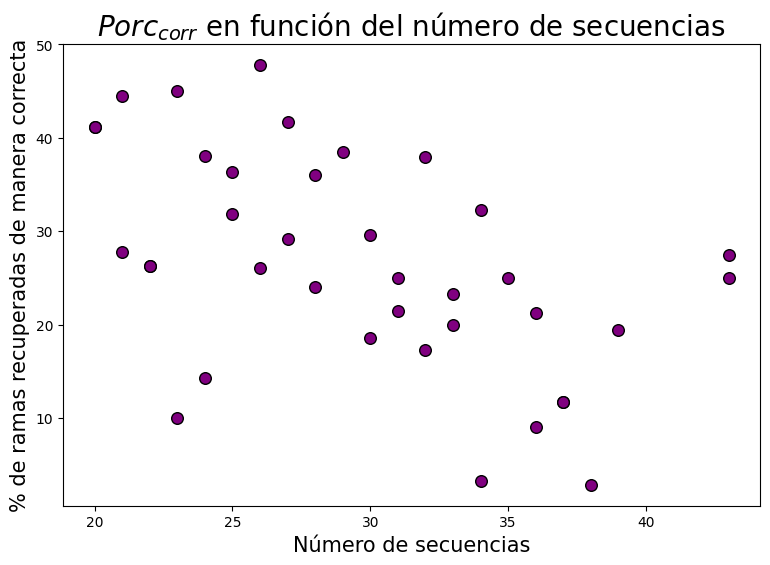

In [3]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='purple', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

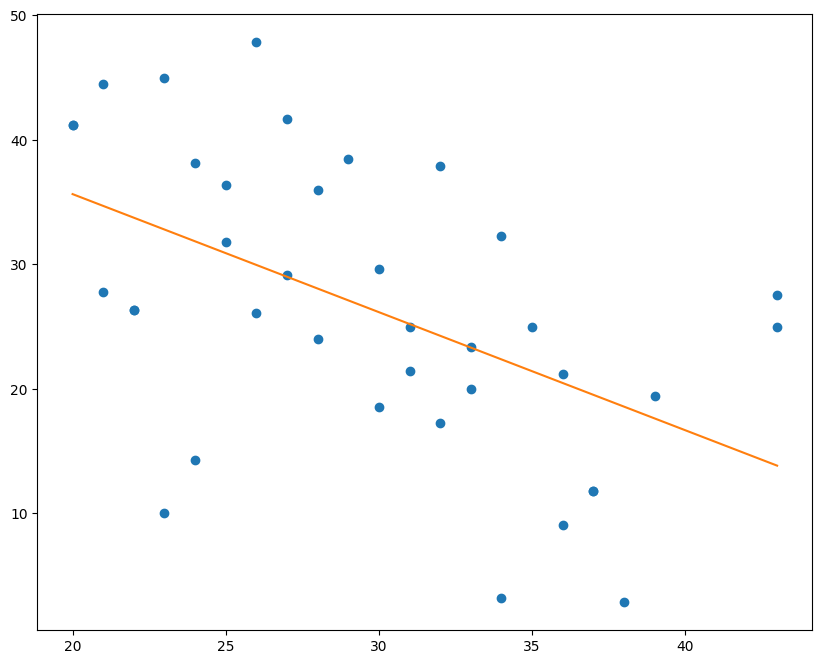

In [4]:
# Create a linear regression model and plot it with the cloud of points

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(rf[['size']], rf['RF'])

fig,ax = plt.subplots(figsize=(10,8))

ax.plot(rf['size'], rf['RF'], 'o')

y_pred = model.predict(rf[['size']])

ax.plot(rf['size'], y_pred)

plt.show()

Then we can try to explain the outliers by using different tree parameters like average branch length or length of sequence. But first, let's identify outliers.

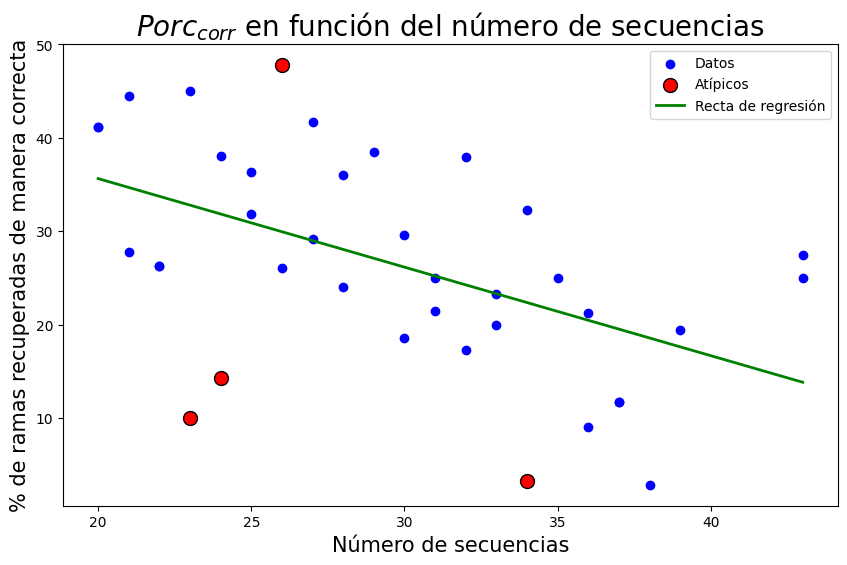

In [5]:
residuals = rf['RF'] - y_pred

# Identify outliers (using z-scores)
threshold = 1.75  # Customize the z-score threshold
outlier_mask = np.abs(zscore(residuals)) > threshold

# Plot the data points and outliers
plt.figure(figsize=(10, 6))
plt.scatter(rf['size'], rf['RF'], label='Datos', color='blue')
plt.scatter(rf['size'][outlier_mask], rf['RF'][outlier_mask], label='Atípicos', color='red', edgecolor='k', s=100)
plt.plot(rf['size'], y_pred, label='Recta de regresión', color='green', linewidth=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.legend()
plt.show()

In [6]:
print(rf['id'][outlier_mask].values)

['48363' '11027' '57060' '57672']


In [7]:
# Median of all rf
median_rf = rf['RF'].median()
print(f'Median of all RF: {median_rf}')

# Mean of all rf
mean_rf = rf['RF'].mean()
print(f'Mean of all RF: {mean_rf}')

Median of all RF: 26.205
Mean of all RF: 26.531578947368423


## Time

In [8]:
time = pd.read_csv('metrics/timer.csv')
# time_table = time.groupby('size')['time'].mean().reset_index()
# time_table['time'] = time_table['time']/1000
# time_table['Media RF'] = grouped_df['Media RF'].values

# print(time_table.to_latex(index=False,
#     float_format="%.2f",
#     caption="Métricas medias por tamaño",
#     label="tab:metricas_qa"))

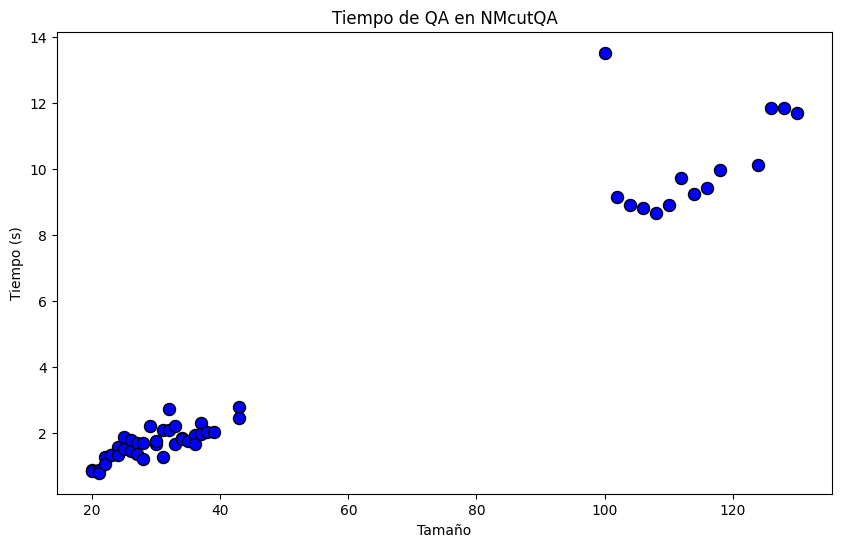

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(time['size'], time['time']/1000, color='blue', edgecolor='k',s=75)
plt.xlabel('Tamaño')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo de QA en NMcutQA')
plt.show()

In [10]:
mean_rf = time['time'].mean()
print(f'Mean of all RF: {mean_rf}')

Mean of all RF: 3965.726516923077


In [11]:
# # Seems linear so, linear regression it is

# model = LinearRegression()

# model.fit(time[['size']], time['time'])

# fig,ax = plt.subplots(figsize=(10,8))

# X = time['size']
# y = time['time']

# ax.plot(X, y, 'o')

# y_pred = model.predict(rf[['size']])

# ax.plot(X, y_pred)

# plt.show()

Text(0.5, 1.0, 'Approximate number of subproblems in NMcutQA')

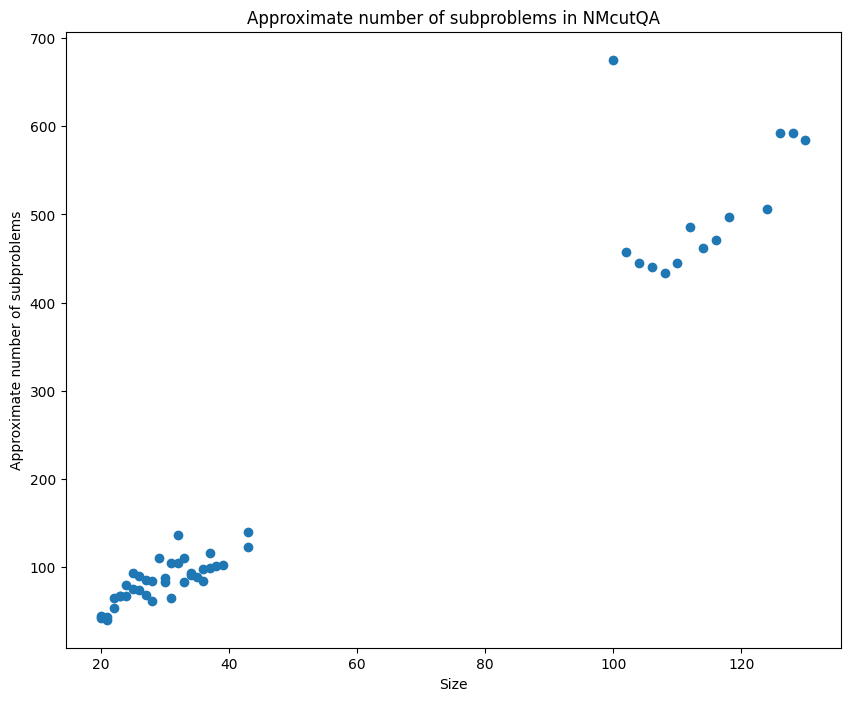

In [12]:
transform_time = time['time']/20

plt.subplots(figsize=(10,8))

plt.plot(time['size'], transform_time, 'o')
plt.xlabel('Size')
plt.ylabel('Approximate number of subproblems')

plt.title('Approximate number of subproblems in NMcutQA')

---
# QAOA

The QAOA, as espected, performed a lot worse than the QA, both in time and RF, let's see the few executions it made

## Time

In [13]:
qaoa_time = pd.read_csv('metrics/timer_qaoa.csv',dtype={'size':int,'time':float})
qaoa_time.head()

,size,name,time
0,20,matrix_10618.npy,1.885833e+07
1,20,matrix_41388.npy,1.871889e+07
2,21,matrix_45255.npy,2.240694e+07
3,21,matrix_48947.npy,2.013079e+07
4,10,matrix_28864.npy,9.110392e+04


In [14]:
mean_rf = qaoa_time['time'].mean()
print(f'Mean of all RF: {mean_rf}')

Mean of all RF: 3162470.433773265


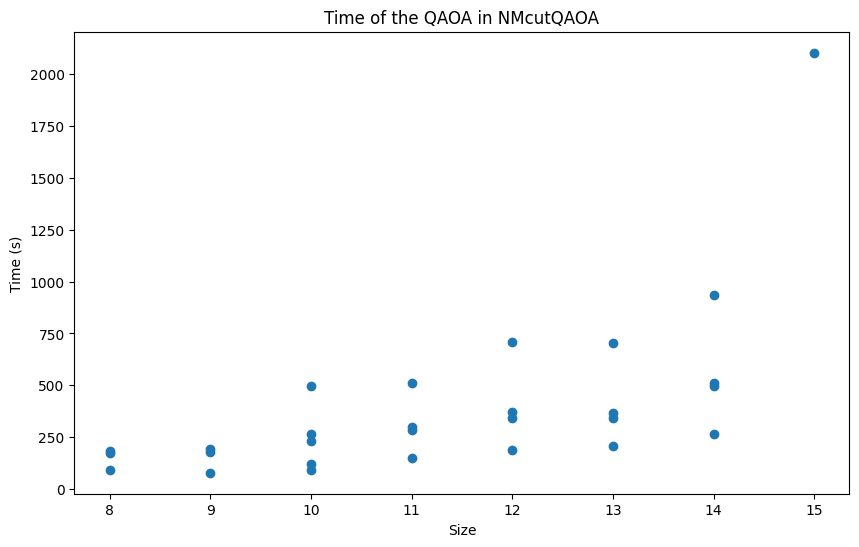

In [15]:
plt.figure(figsize=(10, 6))
filtered_time = qaoa_time[qaoa_time['time'] < 5000000]
plt.plot(filtered_time['size'], (filtered_time['time']/1000), 'o')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.show()

In [16]:
hours = qaoa_time['time'].sum()/1000/3600
print(f'\033[1mThe whole ordeal (4 trees) took {hours} hours to execute\033[22m')

The whole ordeal (4 trees) took 29.867776318969728 hours to execute


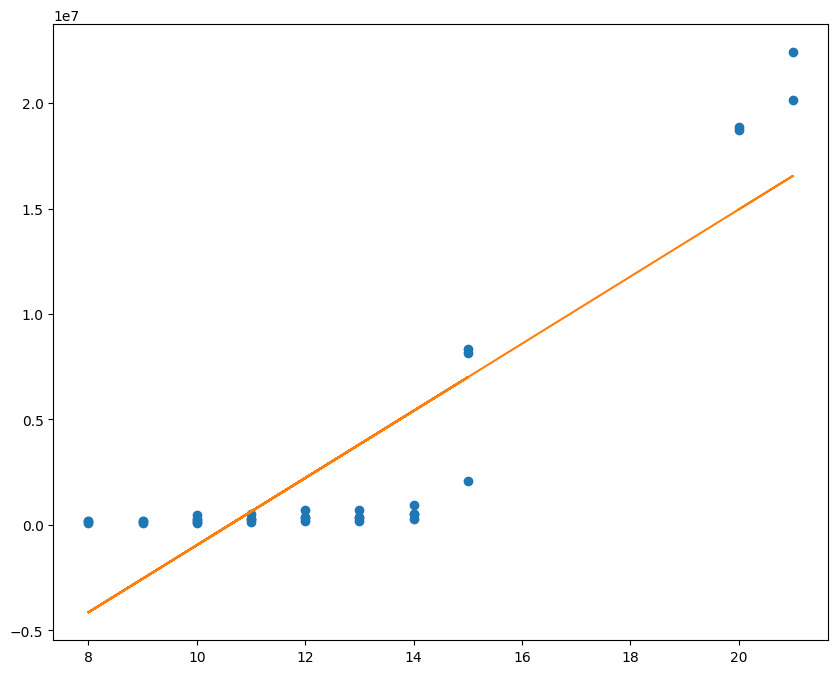

In [17]:
# Seems linear so, linear regression it is

model = LinearRegression()

model.fit(qaoa_time[['size']], qaoa_time['time'])

fig,ax = plt.subplots(figsize=(10,8))

X = qaoa_time['size']
y = qaoa_time['time']

ax.plot(X, y, 'o')

y_pred = model.predict(qaoa_time[['size']])

ax.plot(X, y_pred)

plt.show()

It's stupid to do statistics when having 2 or 3 values, so we can try to use smaller trees. Also:

## RF

In [18]:
rf_qaoa = pd.read_csv('metrics/RF-distance_qaoa.csv')
rf_qaoa.head()

# grouped_df = rf_qaoa.groupby("size", as_index=False)["RF"].mean()
# grouped_time = qaoa_time.groupby("size", as_index=False)["time"].mean()
# grouped_df.insert(1, 'Tiempo (min)', (grouped_time['time'].values/1000)/60)
# # Renombrar la columna de RF para mayor claridad
# grouped_df.rename(columns={"RF": "Media RF",'size':'Tamaño'}, inplace=True)

# print(grouped_df.to_latex(index=False,
#     float_format="%.2f",
#     caption="Media de RF por tamaño",
#     label="tab:metricas_qaoa"))

,size,id,RF
0,10,28864,0.0
1,11,11523,12.5
2,12,7791,0.0
3,13,13951,0.0
4,14,10953,0.0


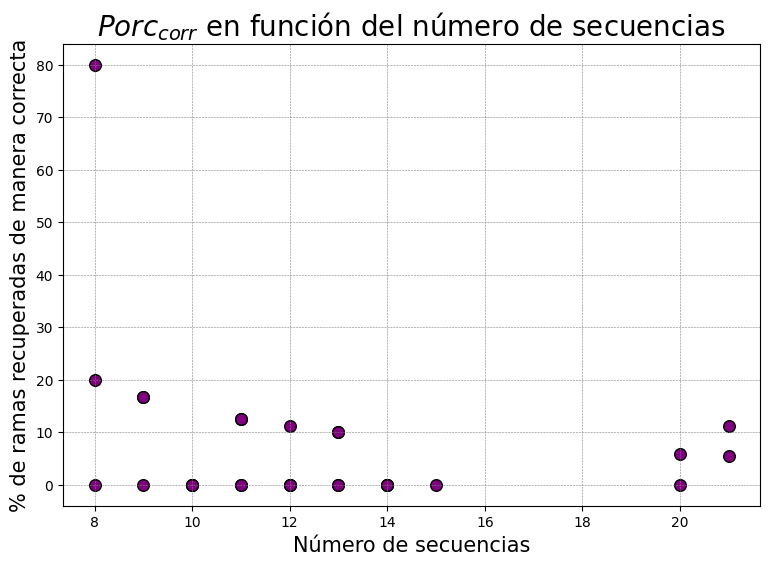

In [19]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.scatter(rf_qaoa['size'], rf_qaoa['RF'], edgecolor='k', color='purple', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)

plt.show()

In [20]:
mean_rf = rf_qaoa['RF'].mean()
print(f'Mean of all RF: {mean_rf}')

Mean of all RF: 6.838709677419355


---
# Comparisons

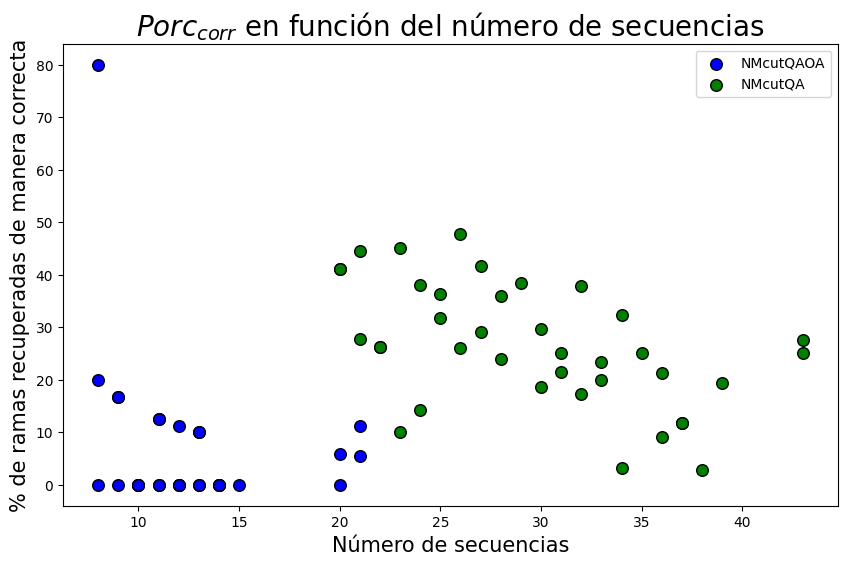

In [21]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(rf_qaoa['size'], rf_qaoa['RF'], edgecolor='k', color='blue', s=70,label='NMcutQAOA')
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='green', s=70,label='NMcutQA')
plt.legend()
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

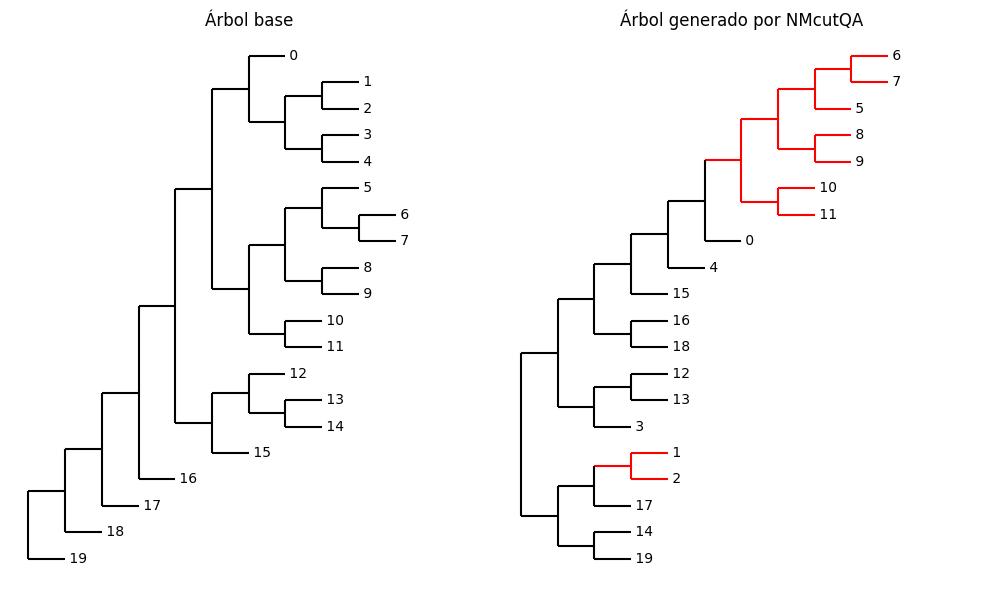

In [22]:
id = 10618
# get size from rf where id=id

size = rf[rf['id'] == str(id)]['size'].values[0]

with open(f'trees/{size}/qa_tree_{id}.newick','r') as file:
    qa_tree = file.read()
    
with open(f'trees/{size}/tree_best_{id}.newick','r') as file:
    biotree = file.read()
    
biotree = re.sub(r'taxon([0-9]+)',lambda match: str(int(match.group(1)) - 1),biotree)
biotree = re.sub(r':[0-9]\.[0-9]+(e-[0-9]+)*',r'',biotree)
# print(biotree)

tree1 = Phylo.read(StringIO(qa_tree), "newick")
# Phylo.draw(tree1)
tree2 = Phylo.read(StringIO(biotree), "newick")
# Phylo.draw(tree2)


# Function to get clade terminal taxa sets by name
def get_clade_taxa_sets(tree):
    return {
        frozenset(term.name for term in clade.get_terminals()) 
        for clade in tree.find_clades() if len(clade.get_terminals()) > 1 and len(clade.get_terminals()) != size  # Only internal clades
    }

# Find common clades based on their terminal taxa
common_taxa_sets = get_clade_taxa_sets(tree1).intersection(get_clade_taxa_sets(tree2))

# Function to color branches with common taxa in red
def color_common_branches(tree, common_taxa_sets):
    for clade in tree.find_clades():
        # Only consider internal clades (with more than one terminal)
        if len(clade.get_terminals()) > 1:
            # Check if the clade's terminals match a common set
            if frozenset(term.name for term in clade.get_terminals()) in common_taxa_sets:
                clade.color = "red"
            else:
                clade.color = "black"  # Default color for non-common branches

# Color the branches in the first tree
color_common_branches(tree1, common_taxa_sets)
# color_common_branches(tree2, common_taxa_sets)

# Create a figure with subplots (side by side)
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot the second tree
Phylo.draw(tree2, do_show=False, axes=axes1)
axes1.set_title("Árbol base")
plt.setp(axes1, xticks=[], yticks=[])  # Remove ticks
axes1.axis('off')  # Remove axes

# Plot the first tree
Phylo.draw(tree1, do_show=False, axes=axes2)
axes2.set_title("Árbol generado por NMcutQA")
plt.setp(axes2, xticks=[], yticks=[])  # Remove ticks
axes2.axis('off')  # Remove axes

# Show the plot
plt.tight_layout()
plt.show()

---
## Comparation

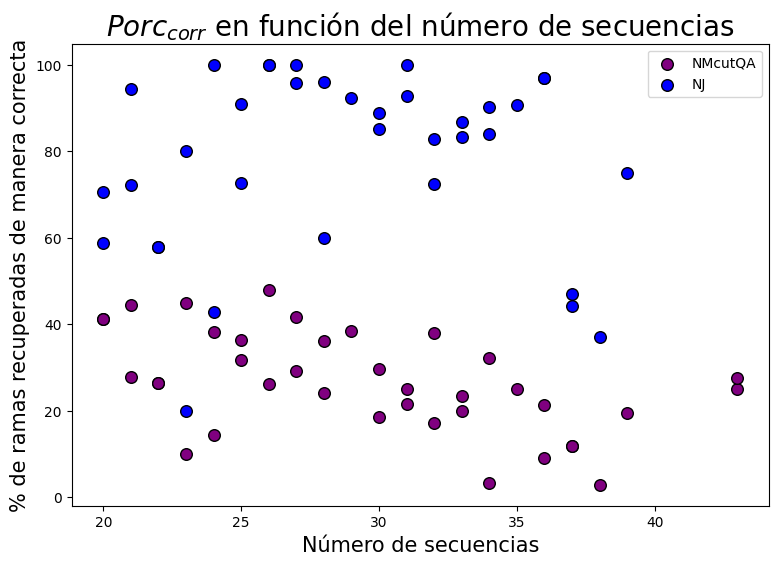

In [23]:
rf_nf = pd.read_csv('metrics/RF-nj.csv')

plt.subplots(figsize=(9, 6))
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='purple', s=70)
plt.scatter(rf_nf['size'], rf_nf['RF'], edgecolor='k', color='blue', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.legend(['NMcutQA','NJ'])
plt.show()

In [24]:
mean_rf = rf_nf['RF'].mean()
print(f'Mean of all RF: {mean_rf}')

Mean of all RF: 78.24083333333333


## Theoretical best

In [25]:
rf_bf = pd.read_csv('metrics/RF-distance_bf.csv')

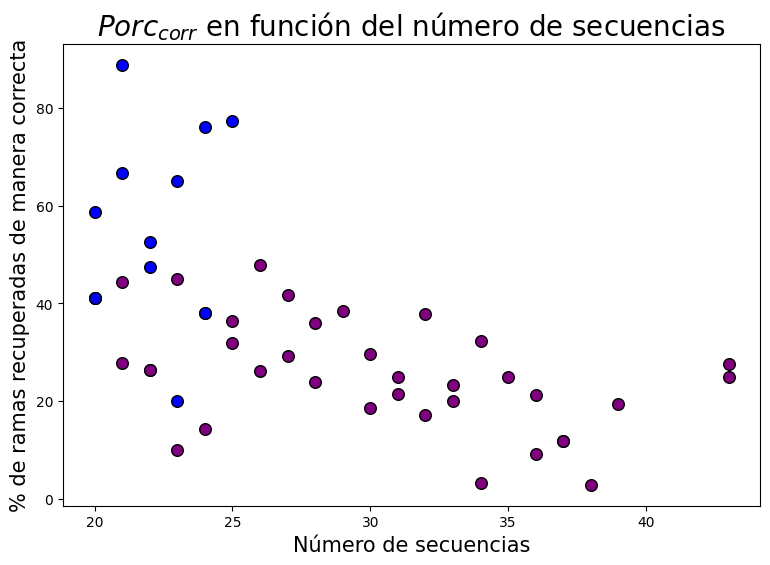

In [26]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='purple', s=70)
plt.scatter(rf_bf['size'], rf_bf['RF'], edgecolor='k', color='blue', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

In [27]:
mean_rf = rf_bf['RF'].mean()
print(f'Mean of all RF: {mean_rf}')
print(f'Percentage: {26.547222222222/mean_rf*100}%')

Mean of all RF: 57.46545454545455
Percentage: 46.19683674689015%


# Qiskit QAOA

## RF distance

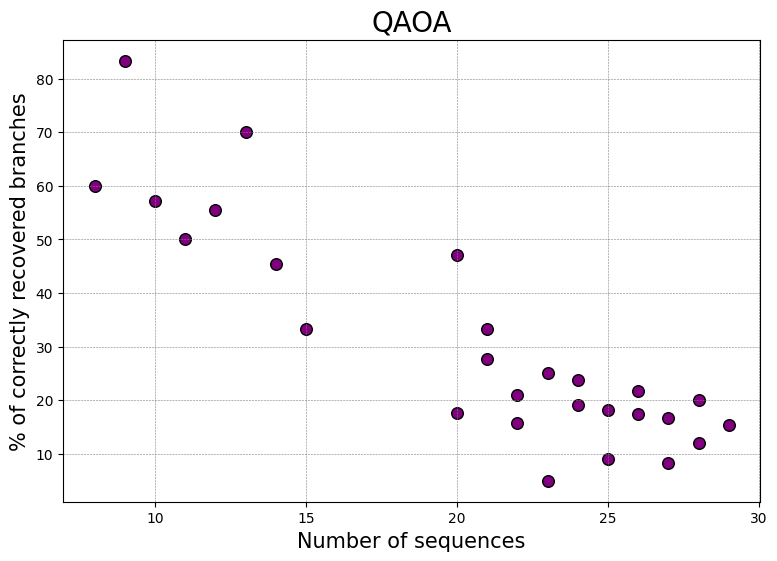

In [28]:
qiskit_df = pd.read_csv('metrics/RF-distance_qiskit.csv')

# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(qiskit_df['size'], qiskit_df['RF'], edgecolor='k', color='purple', s=70)
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('QAOA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

Let's compare the results using qiskit QAOA with the results obtained using our QAOA. However, we still get the same downward pattern that we get with the QA.

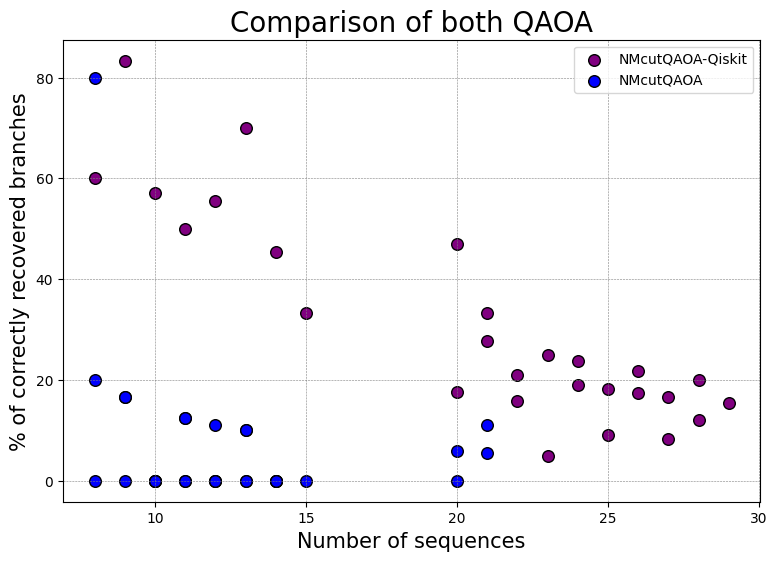

In [29]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(qiskit_df['size'], qiskit_df['RF'], edgecolor='k', color='purple', s=70,label='NMcutQAOA-Qiskit')
plt.scatter(rf_qaoa['size'], rf_qaoa['RF'], edgecolor='k', color='blue', s=70,label='NMcutQAOA')
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison of both QAOA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

The results are really good, they all get better results than our own QAOA, so let's then compare it to the QA method.

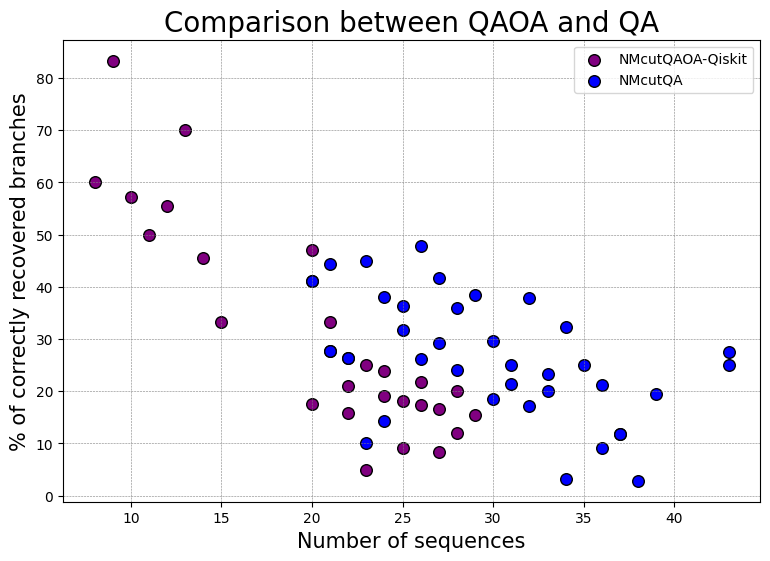

In [30]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(qiskit_df['size'], qiskit_df['RF'], edgecolor='k', color='purple', s=70,label='NMcutQAOA-Qiskit')
plt.scatter(rf['size'], rf['RF'], edgecolor='k', color='blue', s=70,label='NMcutQA')

# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison between QAOA and QA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

Full diagram

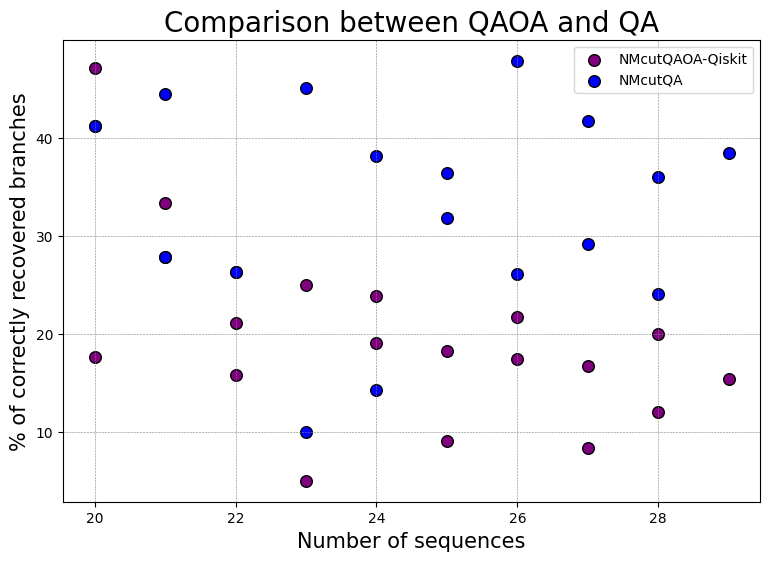

In [31]:
# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(qiskit_df[qiskit_df['size']>15]['size'], qiskit_df[qiskit_df['size']>15]['RF'], edgecolor='k', color='purple', s=70,label='NMcutQAOA-Qiskit')
plt.scatter(rf[rf['size']<30]['size'], rf[rf['size']<30]['RF'], edgecolor='k', color='blue', s=70,label='NMcutQA')

# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison between QAOA and QA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

As expected we get worst results than with QA but still really good results for QAOA method. However the time is a different story.


In [32]:
mean_rf = qiskit_df['RF'].mean()
min_rf = qiskit_df['RF'].min()
max_rf = qiskit_df['RF'].max()
print(f'Mean of all RF: {mean_rf}')
print(f'Minimum of all RF: {min_rf}')
print(f'Maximum of all RF: {max_rf}')

Mean of all RF: 30.707777777777775
Minimum of all RF: 5.0
Maximum of all RF: 83.33



## Time


In [33]:
qiskit_time = pd.read_csv('metrics/timer_qaoa_qiskit.csv', dtype={'size':int,'time':float})
qiskit_time.head()

,size,name,time
0,8,matrix_1822.npy,1867.223145
1,9,matrix_32709.npy,3135.470947
2,10,matrix_28864.npy,4566.642334
3,11,matrix_11523.npy,5367.900879
4,12,matrix_7791.npy,8472.245361


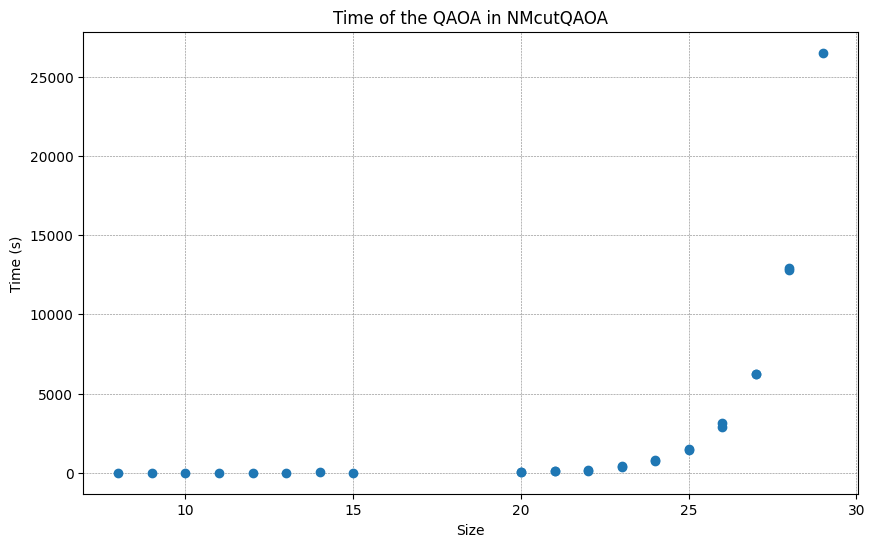

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(qiskit_time['size'], (qiskit_time['time']/1000), 'o', label='NMcutQAOA-Qiskit')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

Wow, this is a pretty neat exponential function. This makes me wanna try fitting it.

Fitted parameters: a=1.9651893722740862e-05, b=0.724907598723578, c=12.642793112870798
Fitted function: y = 1.965e-05 * exp(0.725 * x) + 12.643
R^2: 0.9999283545591051


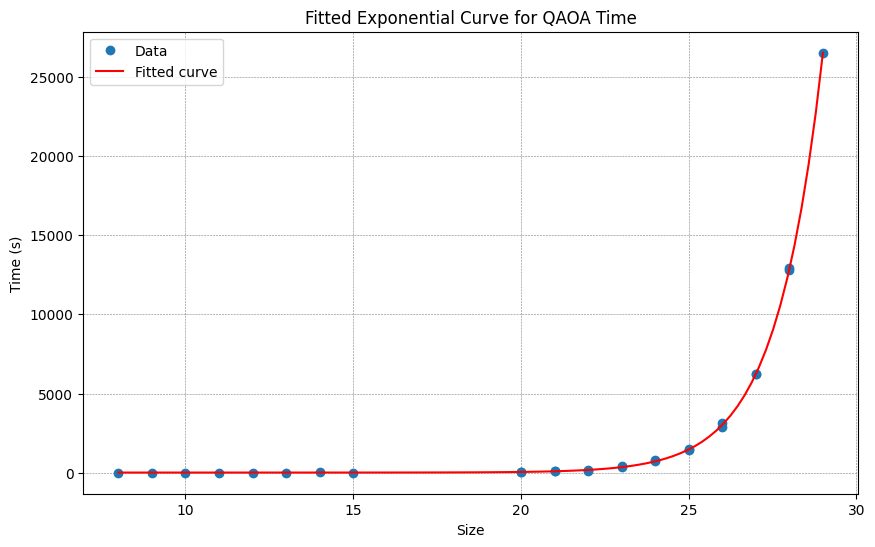

In [35]:
from scipy.optimize import curve_fit

exp = lambda x, a, b, c: a * np.exp(b * x) + c

x1 = np.linspace(8,29,100)
x = qiskit_time['size']
y = qiskit_time['time']/1000

params, cov = curve_fit(exp, x, y)
print(f'Fitted parameters: a={params[0]}, b={params[1]}, c={params[2]}')
print(f'Fitted function: y = {params[0]:.3e} * exp({params[1]:.3f} * x) + {params[2]:.3f}')
print(f'R^2: {1 - np.sum((y - exp(x, *params))**2) / np.sum((y - np.mean(y))**2)}')
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Data')
plt.plot(x1, exp(x1, *params), label='Fitted curve', color='red')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Fitted Exponential Curve for QAOA Time')
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

As the graph grows exponentially (because the circuit size grows exponentially), let's only graph the time for the values with $size<26$.

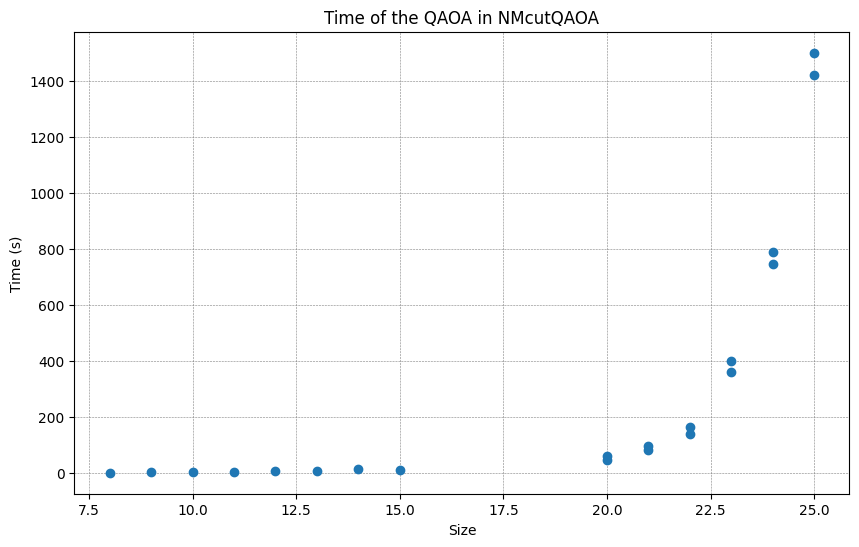

In [36]:
plt.figure(figsize=(10, 6))
filtered_qiskit_time = qiskit_time[qiskit_time['size'] < 26]
plt.plot(filtered_qiskit_time['size'], (filtered_qiskit_time['time']/1000), 'o', label='NMcutQAOA-Qiskit')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

We still see the same growth pattern. Let's compare (though not useful) the times with the QA approach.

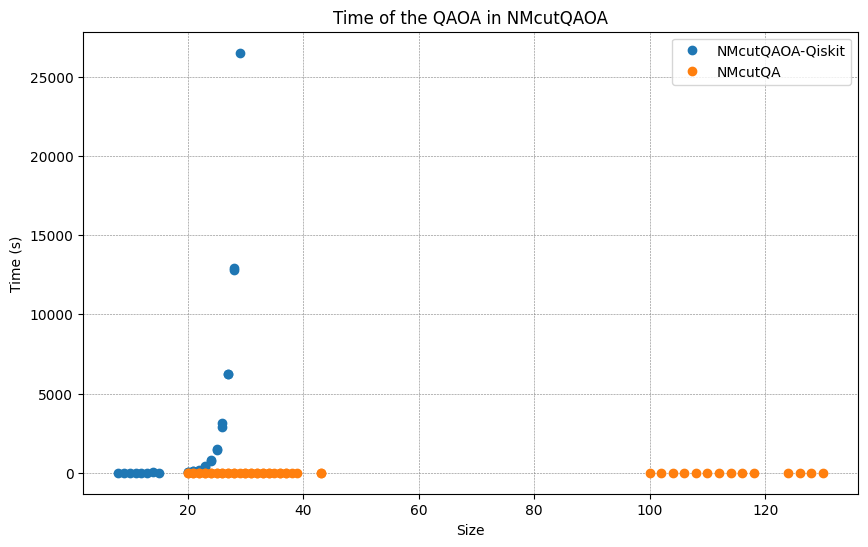

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(qiskit_time['size'], (qiskit_time['time']/1000), 'o', label='NMcutQAOA-Qiskit')
plt.plot(time['size'], (time['time']/1000), 'o', label='NMcutQA')
plt.xlabel('Size')
plt.ylabel('Time (s)')
plt.title('Time of the QAOA in NMcutQAOA')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

As expected, we can see a much better growth, because the growth from the QA is $\mathcal{O}(n\log n)$.

Finally, let's rewrite the graph comparison with NJ, including the QAOA experiments.

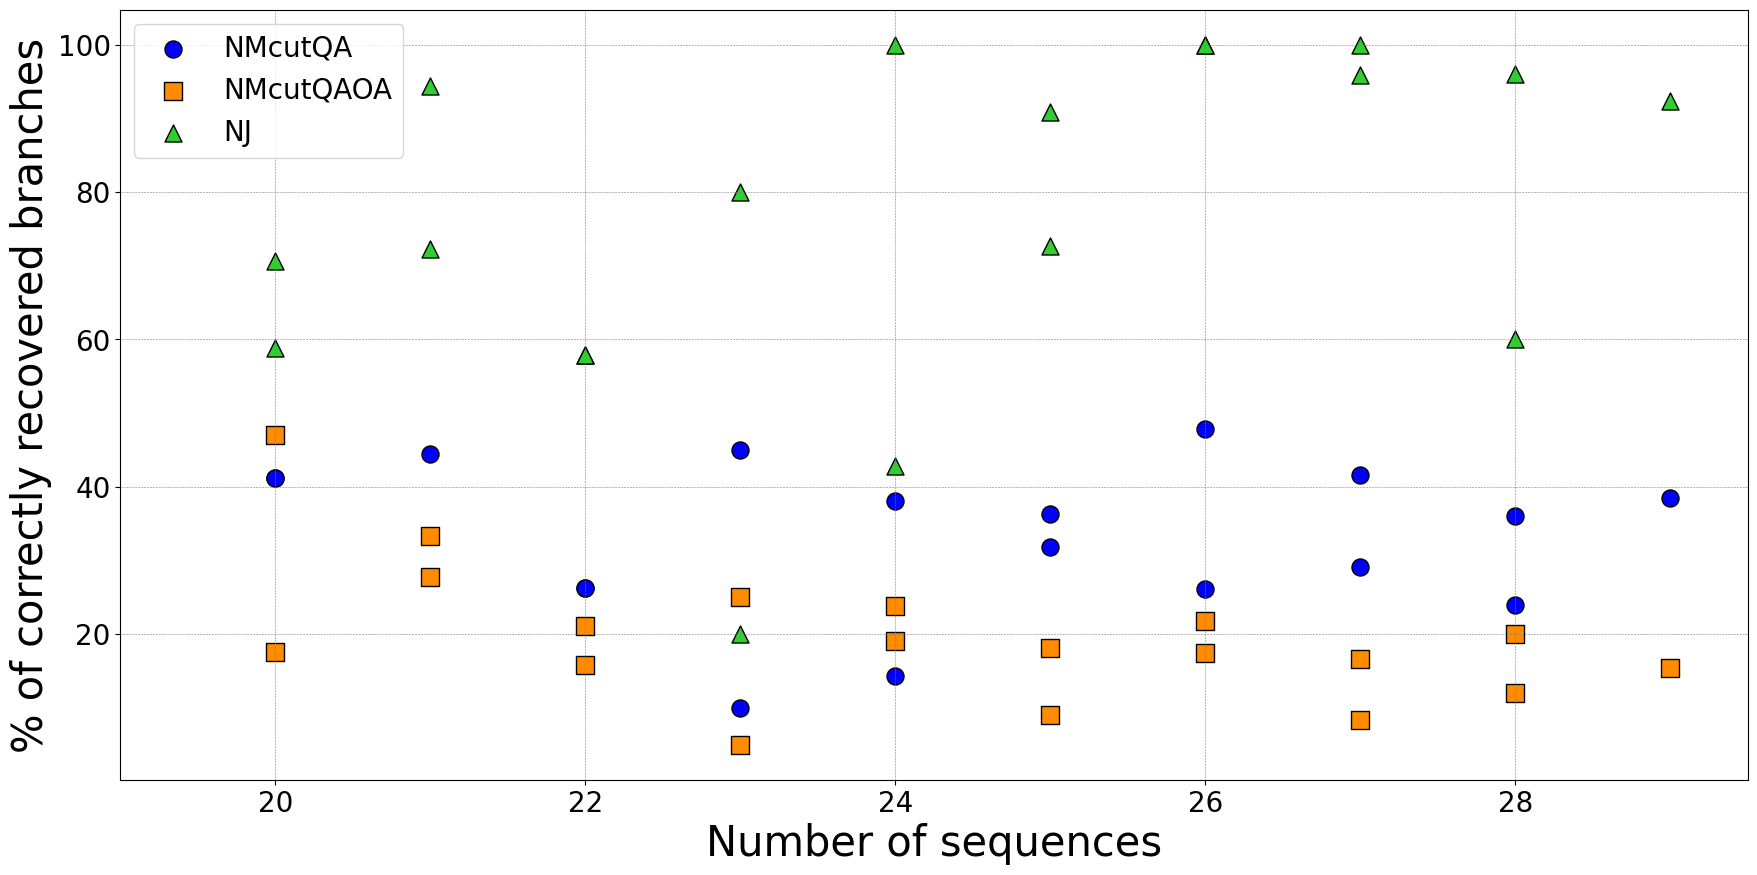

In [38]:
rf_nf = pd.read_csv('metrics/RF-nj.csv')

filtered_rf = rf[rf['size'] < 30]
filtered_rf_nf = rf_nf[rf_nf['size'] < 30]

plt.subplots(figsize=(21, 10))
plt.scatter(filtered_rf['size'], filtered_rf['RF'], edgecolor='k', color='blue', s=150, marker='o', label='NMcutQA')
plt.scatter(qiskit_df[qiskit_df['size']>19]['size'], qiskit_df[qiskit_df['size']>19]['RF'], edgecolor='k', color='darkorange', s=150, marker='s', label='NMcutQAOA')
plt.scatter(filtered_rf_nf['size'], filtered_rf_nf['RF'], edgecolor='k', color='limegreen', s=150, marker='^', label='NJ')
plt.xlabel('Number of sequences',fontdict={'fontsize': 30})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([19,29.5])
# plt.title('Comparison between QAOA, QA and NJ', fontsize=30)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend(fontsize=20, loc='upper left').get_frame()  # Set legend background transparency
plt.show()

In [39]:
mean_rf = filtered_rf['RF'].mean()
min_rf = filtered_rf['RF'].min()
max_rf = filtered_rf['RF'].max()
print(f'Mean of all RF: {mean_rf}')
print(f'Minimum of all RF: {min_rf}')
print(f'Maximum of all RF: {max_rf}')

Mean of all RF: 32.9478947368421
Minimum of all RF: 10.0
Maximum of all RF: 47.83


In [40]:
mean_rf = filtered_rf_nf['RF'].mean()
min_rf = filtered_rf_nf['RF'].min()
max_rf = filtered_rf_nf['RF'].max()
print(f'Mean of all RF: {mean_rf}')
print(f'Minimum of all RF: {min_rf}')
print(f'Maximum of all RF: {max_rf}')

Mean of all RF: 76.97315789473683
Minimum of all RF: 20.0
Maximum of all RF: 100.0


In [41]:
filtered_qiskit = qiskit_df[qiskit_df['size'] >19]
min_qiskit = filtered_qiskit['RF'].min()
max_qiskit = filtered_qiskit['RF'].max()
print(f'Minimum of all RF (NMcutQAOA): {min_qiskit}')
print(f'Maximum of all RF (NMcutQAOA): {max_qiskit}')
avg_qiskit = filtered_qiskit['RF'].mean()
print(f'Average of all RF (NMcutQAOA): {avg_qiskit}')

Minimum of all RF (NMcutQAOA): 5.0
Maximum of all RF (NMcutQAOA): 47.06
Average of all RF (NMcutQAOA): 19.7


We can create a tree using QAOA like we did for QA.

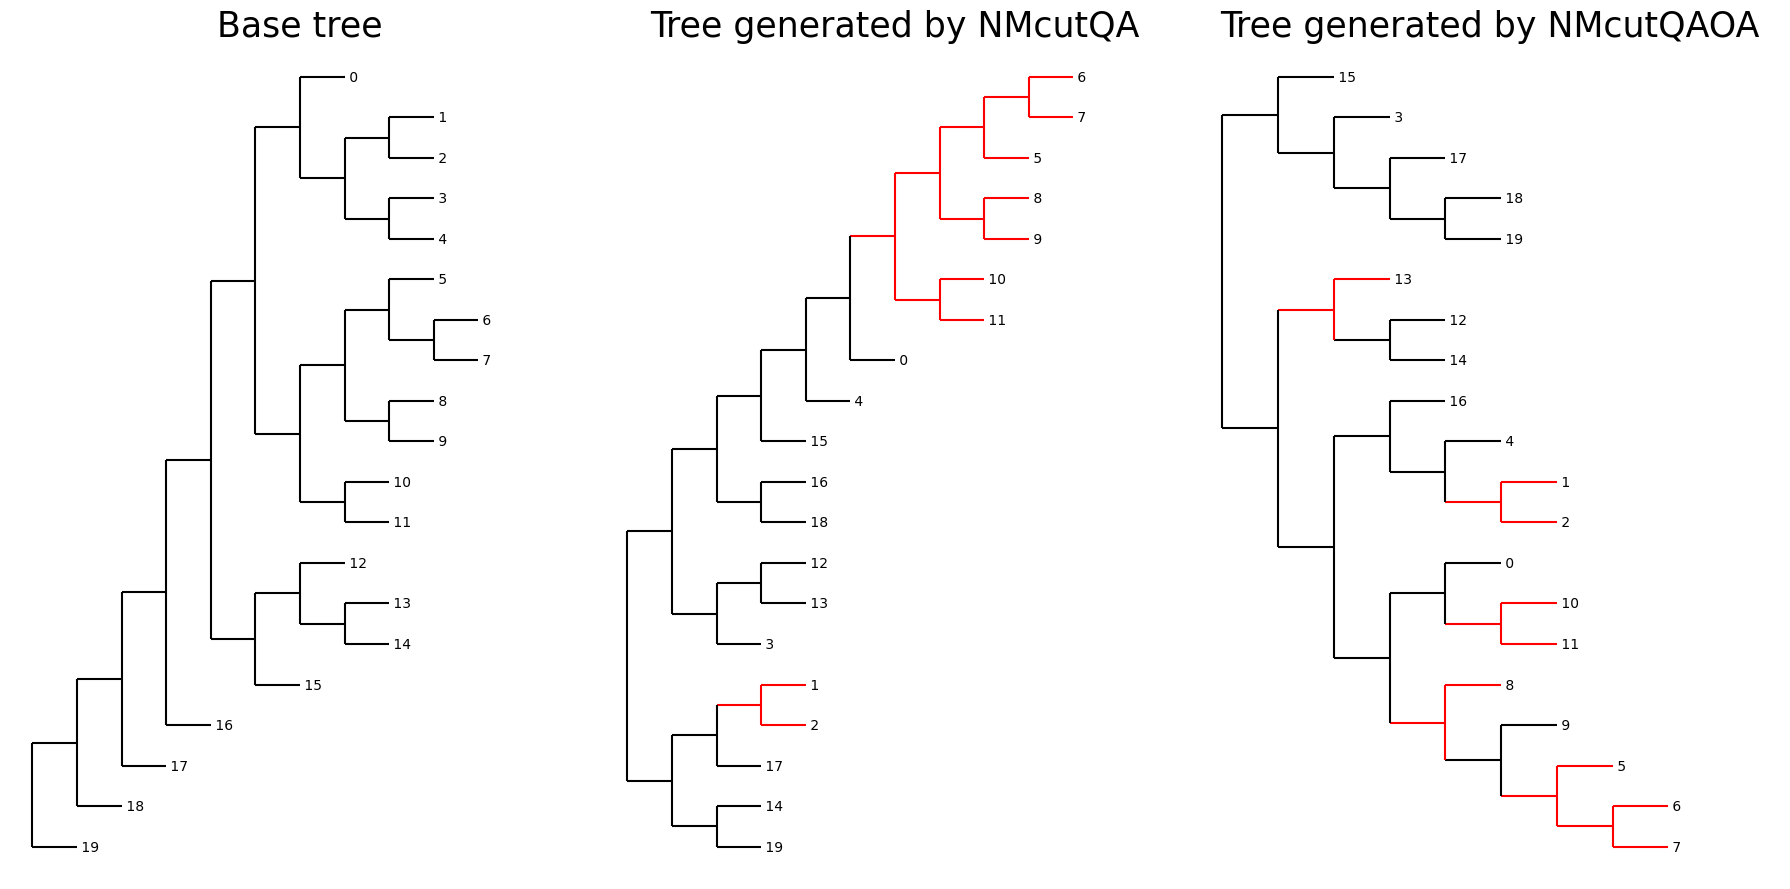

In [42]:
id = 10618
# get size from rf where id=id

size = rf[rf['id'] == str(id)]['size'].values[0]

with open(f'trees/{size}/qa_tree_{id}.newick','r') as file:
    qa_tree = file.read()
    
with open(f'trees/{size}/tree_best_{id}.newick','r') as file:
    biotree = file.read()
    
with open(f'trees/{size}/qiskit_tree_{id}.newick','r') as file:
    qiskit_tree = file.read()
    
biotree = re.sub(r'taxon([0-9]+)',lambda match: str(int(match.group(1)) - 1),biotree)
biotree = re.sub(r':[0-9]\.[0-9]+(e-[0-9]+)*',r'',biotree)
# print(biotree)

tree1 = Phylo.read(StringIO(qa_tree), "newick")
# Phylo.draw(tree1)
tree2 = Phylo.read(StringIO(biotree), "newick")
# Phylo.draw(tree2)
tree3 = Phylo.read(StringIO(qiskit_tree), "newick")


# Function to get clade terminal taxa sets by name
def get_clade_taxa_sets(tree):
    return {
        frozenset(term.name for term in clade.get_terminals()) 
        for clade in tree.find_clades() if len(clade.get_terminals()) > 1 and len(clade.get_terminals()) != size  # Only internal clades
    }

# Find common clades based on their terminal taxa
common_taxa_sets = get_clade_taxa_sets(tree1).intersection(get_clade_taxa_sets(tree2))
common_taxa_sets_qaoa = get_clade_taxa_sets(tree3).intersection(get_clade_taxa_sets(tree2))

# Function to color branches with common taxa in red
def color_common_branches(tree, common_taxa_sets, color = "red"):
    for clade in tree.find_clades():
        # Only consider internal clades (with more than one terminal)
        if len(clade.get_terminals()) > 1:
            # Check if the clade's terminals match a common set
            if frozenset(term.name for term in clade.get_terminals()) in common_taxa_sets:
                clade.color = color
            else:
                clade.color = "black"  # Default color for non-common branches

# Color the branches in the first tree
color_common_branches(tree1, common_taxa_sets)
color_common_branches(tree3, common_taxa_sets_qaoa)

# Create a figure with subplots (side by side)
fig, (axes1, axes2, axes3) = plt.subplots(1, 3, figsize=(18, 9))

# Plot the second tree
Phylo.draw(tree2, do_show=False, axes=axes1)
axes1.set_title("Base tree",fontdict={'fontsize': 25})
plt.setp(axes1, xticks=[], yticks=[])  # Remove ticks
axes1.axis('off')  # Remove axes

# Plot the first tree
Phylo.draw(tree1, do_show=False, axes=axes2)
axes2.set_title("Tree generated by NMcutQA",fontdict={'fontsize': 25})
plt.setp(axes2, xticks=[], yticks=[])  # Remove ticks
axes2.axis('off')  # Remove axes

# Plot the third tree
Phylo.draw(tree3, do_show=False, axes=axes3)
axes3.set_title("Tree generated by NMcutQAOA",fontdict={'fontsize': 25})
plt.setp(axes3, xticks=[], yticks=[])  # Remove ticks
axes3.axis('off')  # Remove axes

# Show the plot
plt.tight_layout()
plt.show()

Comparison with QA, QAOA and brute force NMcut, we can see how much worse are the approximate methods.

In [58]:
sa_df = pd.read_csv('metrics/RF-distance-sa.csv')

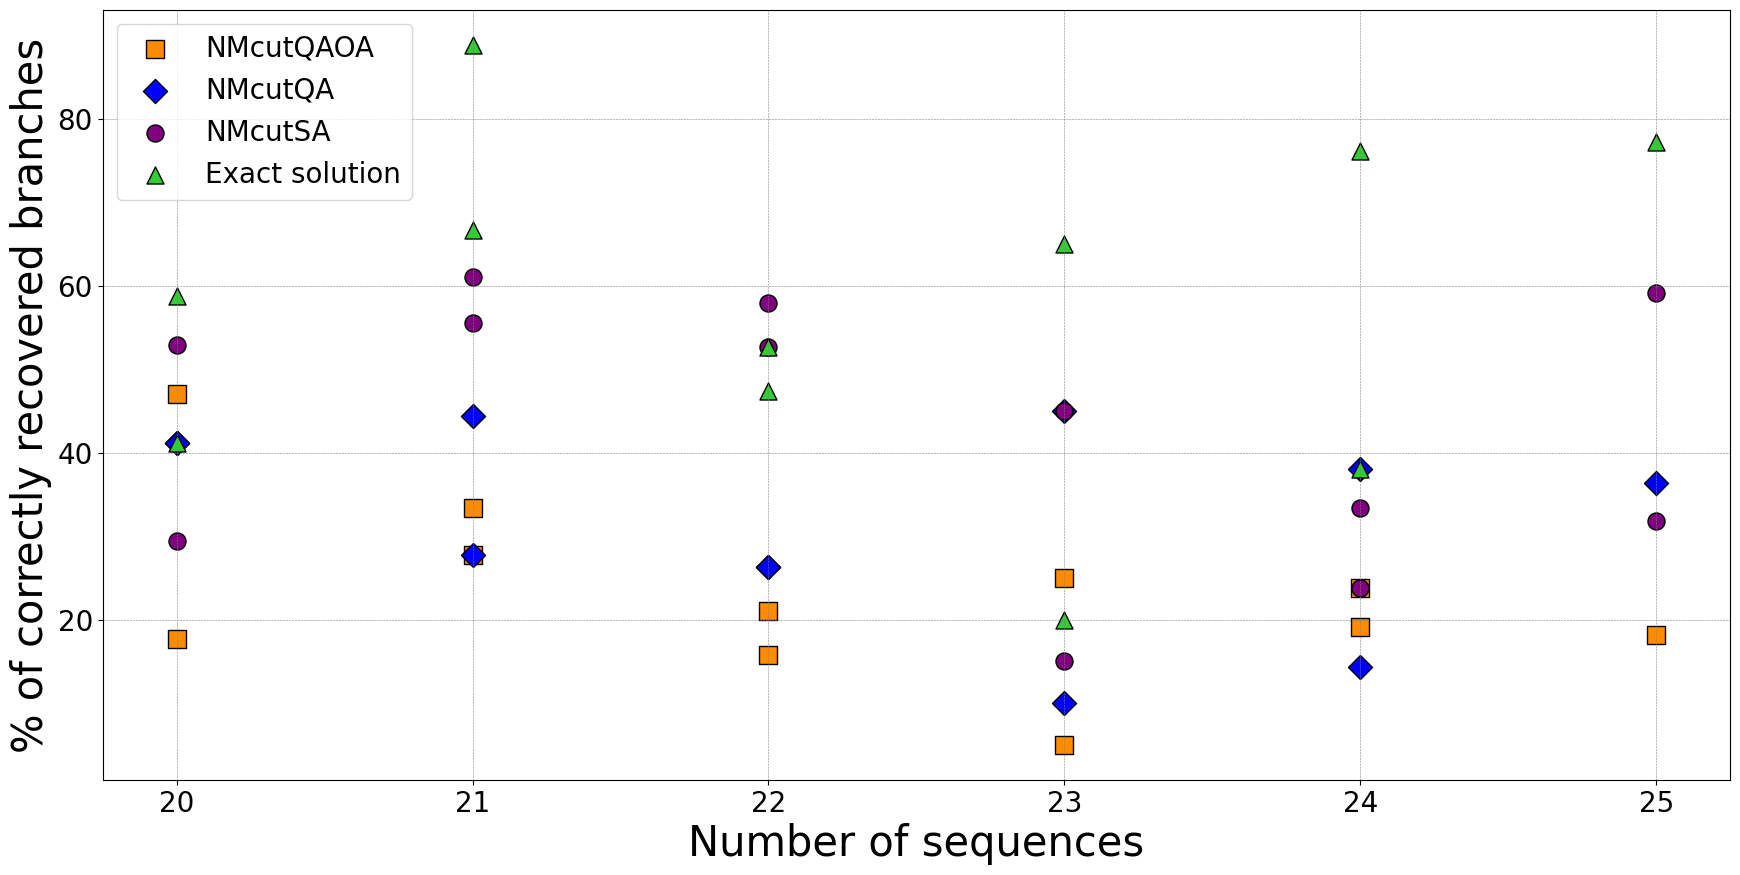

In [63]:
filtered_rf = rf[rf['size'] < 26]
filtered_rf = filtered_rf[filtered_rf['id']!= '40617']
filtered_qiskit = qiskit_df[qiskit_df['size'] < 26]
filtered_qiskit = filtered_qiskit[filtered_qiskit['size'] > 19]
filtered_qiskit = filtered_qiskit[filtered_qiskit['id']!= 40617]
jitter = 0.1
plt.subplots(figsize=(21, 10))


plt.scatter(filtered_qiskit['size'], filtered_qiskit['RF'], edgecolor='k', color='darkorange', s=150, marker='s', label='NMcutQAOA')
plt.scatter(filtered_rf['size'], filtered_rf['RF'], edgecolor='k', color='blue', s=150, marker='D', label='NMcutQA')
plt.scatter(sa_df['size'], sa_df['RF'], edgecolor='k', color='purple', s=150,marker='o',label='NMcutSA')
plt.scatter(rf_bf['size'], rf_bf['RF'], edgecolor='k', color='limegreen', s=150, marker='^', label='Exact solution')



plt.xlabel('Number of sequences',fontdict={'fontsize': 30})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('Comparison between QAOA, QA and Exact solution', fontsize=30)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend(fontsize=20)
plt.show()

## QAOA default and FakeManila


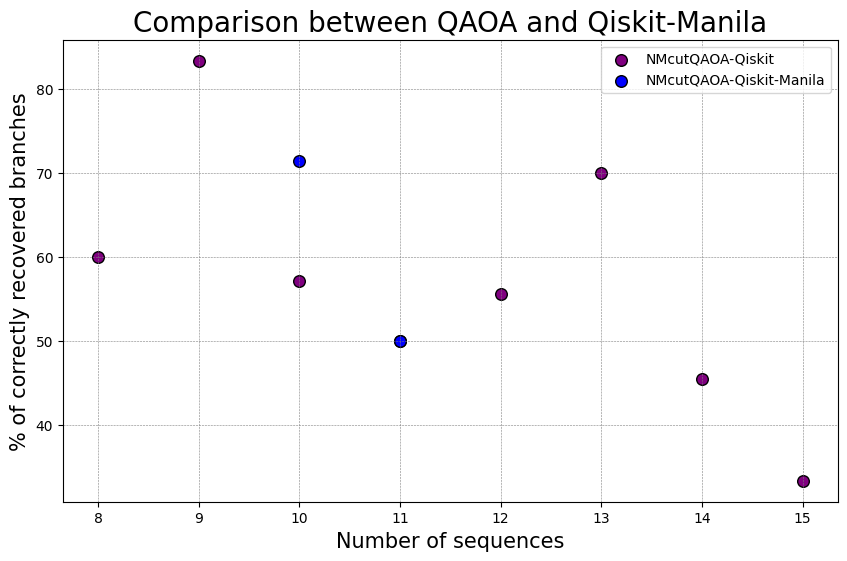

In [44]:
manila_df = pd.read_csv('metrics/RF-distance_qiskit_manila.csv')

filtered_qiskit = qiskit_df[qiskit_df['size'] < 16]

plt.subplots(figsize=(10, 6))

plt.scatter(filtered_qiskit['size'], filtered_qiskit['RF'], edgecolor='k', color='purple', s=70,label='NMcutQAOA-Qiskit')
plt.scatter(manila_df['size'], manila_df['RF'], edgecolor='k', color='blue', s=70,label='NMcutQAOA-Qiskit-Manila')
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison between QAOA and Qiskit-Manila', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

## UPGMA comparison

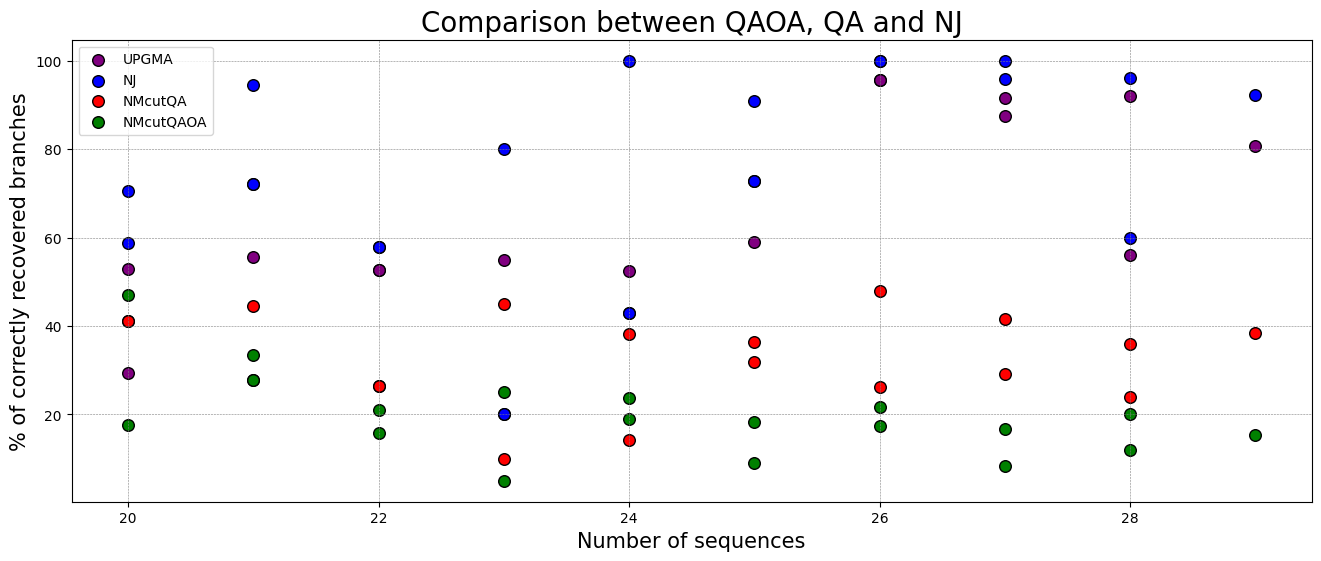

In [45]:
upgma_df = pd.read_csv('metrics/RF-upgma.csv')

filtered_rf = rf[rf['size'] < 30]
filtered_rf_nf = rf_nf[rf_nf['size'] < 30]

plt.subplots(figsize=(16, 6))
plt.scatter(upgma_df['size'], upgma_df['RF'], edgecolor='k', color='purple', s=70,label='UPGMA')
plt.scatter(filtered_rf_nf['size'], filtered_rf_nf['RF'], edgecolor='k', color='blue', s=70,label='NJ')
plt.scatter(filtered_rf['size'], filtered_rf['RF'], edgecolor='k', color='red', s=70,label='NMcutQA')
plt.scatter(qiskit_df[qiskit_df['size'] >19]['size'], qiskit_df[qiskit_df['size'] >19]['RF'], edgecolor='k', color='green', s=70,label='NMcutQAOA')
plt.xlabel('Number of sequences',fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 15})
plt.title('Comparison between QAOA, QA and NJ', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend()
plt.show()

## Noisy QAOA

We will use some Fake providers, especifically FakeAlgiers and FakeGuadalupe to try to see how the QPU noise affects the execution

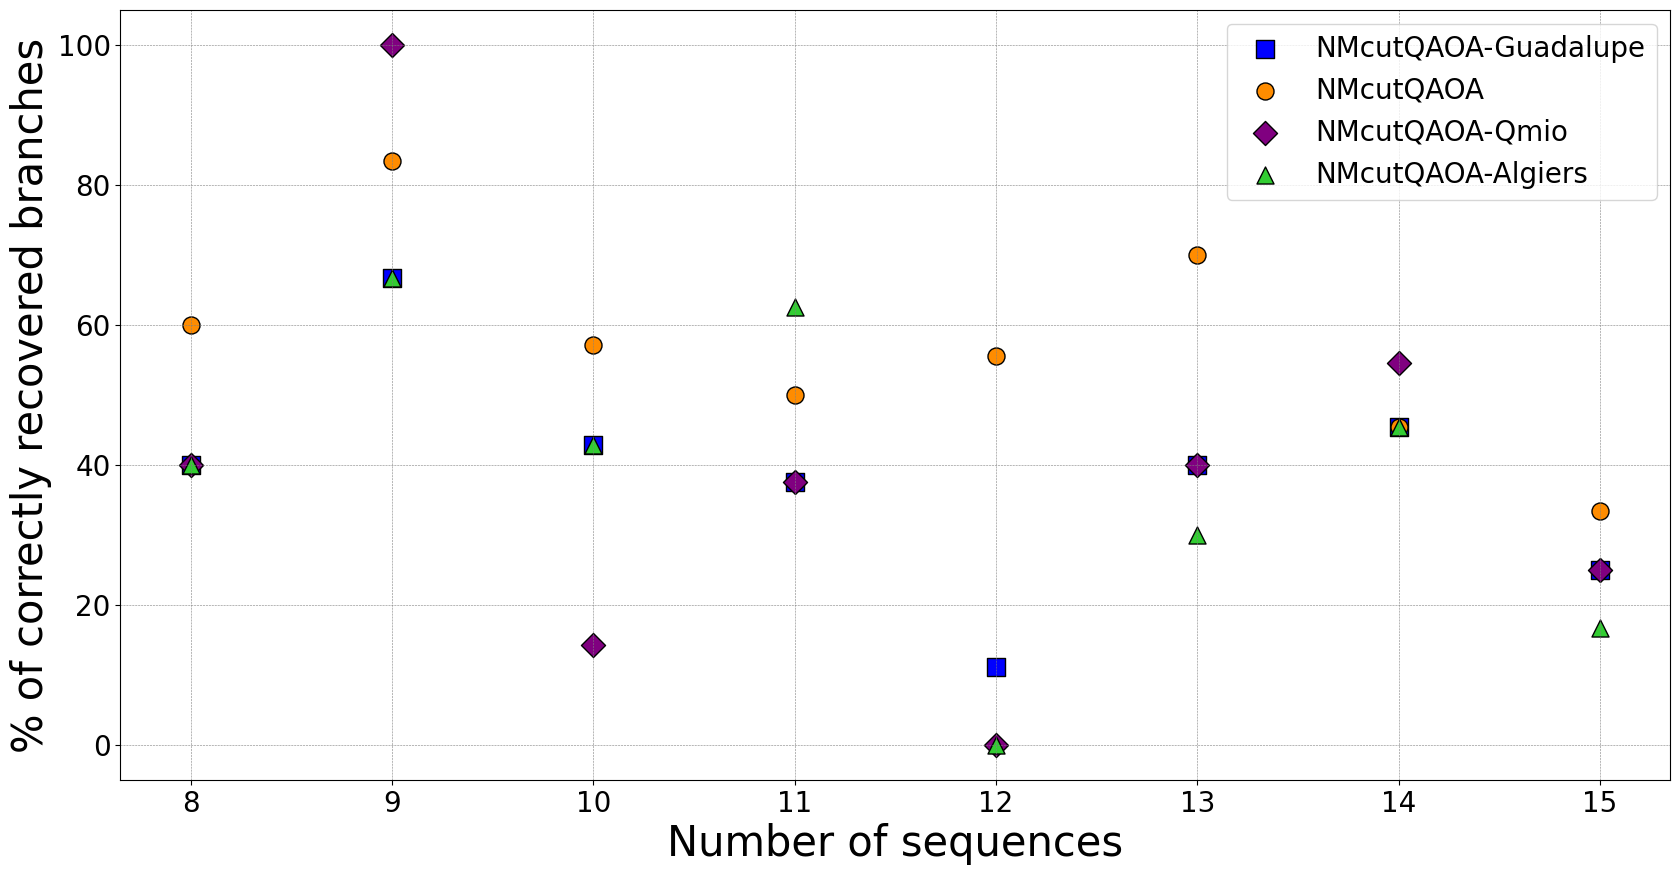

In [46]:
guadalupe_df = pd.read_csv('metrics/RF-distance_qiskit_guadelupe.csv')
algiers_df = pd.read_csv('metrics/RF-distance_qiskit_algiers.csv')
qmio_df = pd.read_csv('metrics/RF-distance_qmio.csv')

filtered_qiskit = qiskit_df[qiskit_df['size'] < 16]

plt.subplots(figsize=(20, 10))
plt.scatter(guadalupe_df['size'], guadalupe_df['RF'], edgecolor='k', color='blue', s=150,marker='s',label='NMcutQAOA-Guadalupe')
plt.scatter(filtered_qiskit['size'], filtered_qiskit['RF'], edgecolor='k', color='darkorange', s=150,label='NMcutQAOA')
plt.scatter(qmio_df['size'], qmio_df['RF'], edgecolor='k', color='purple', s=150,marker='D',label='NMcutQAOA-Qmio')
plt.scatter(algiers_df['size'], algiers_df['RF'], edgecolor='k', color='limegreen', s=150,marker='^',label='NMcutQAOA-Algiers')
plt.xlabel('Number of sequences',fontdict={'fontsize': 30})
plt.ylabel('% of correctly recovered branches',fontdict={'fontsize': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('Comparison between Aer, FakeAlgiers and FakeGuadalupeV2', fontsize=30)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.legend(fontsize=20)
plt.show()

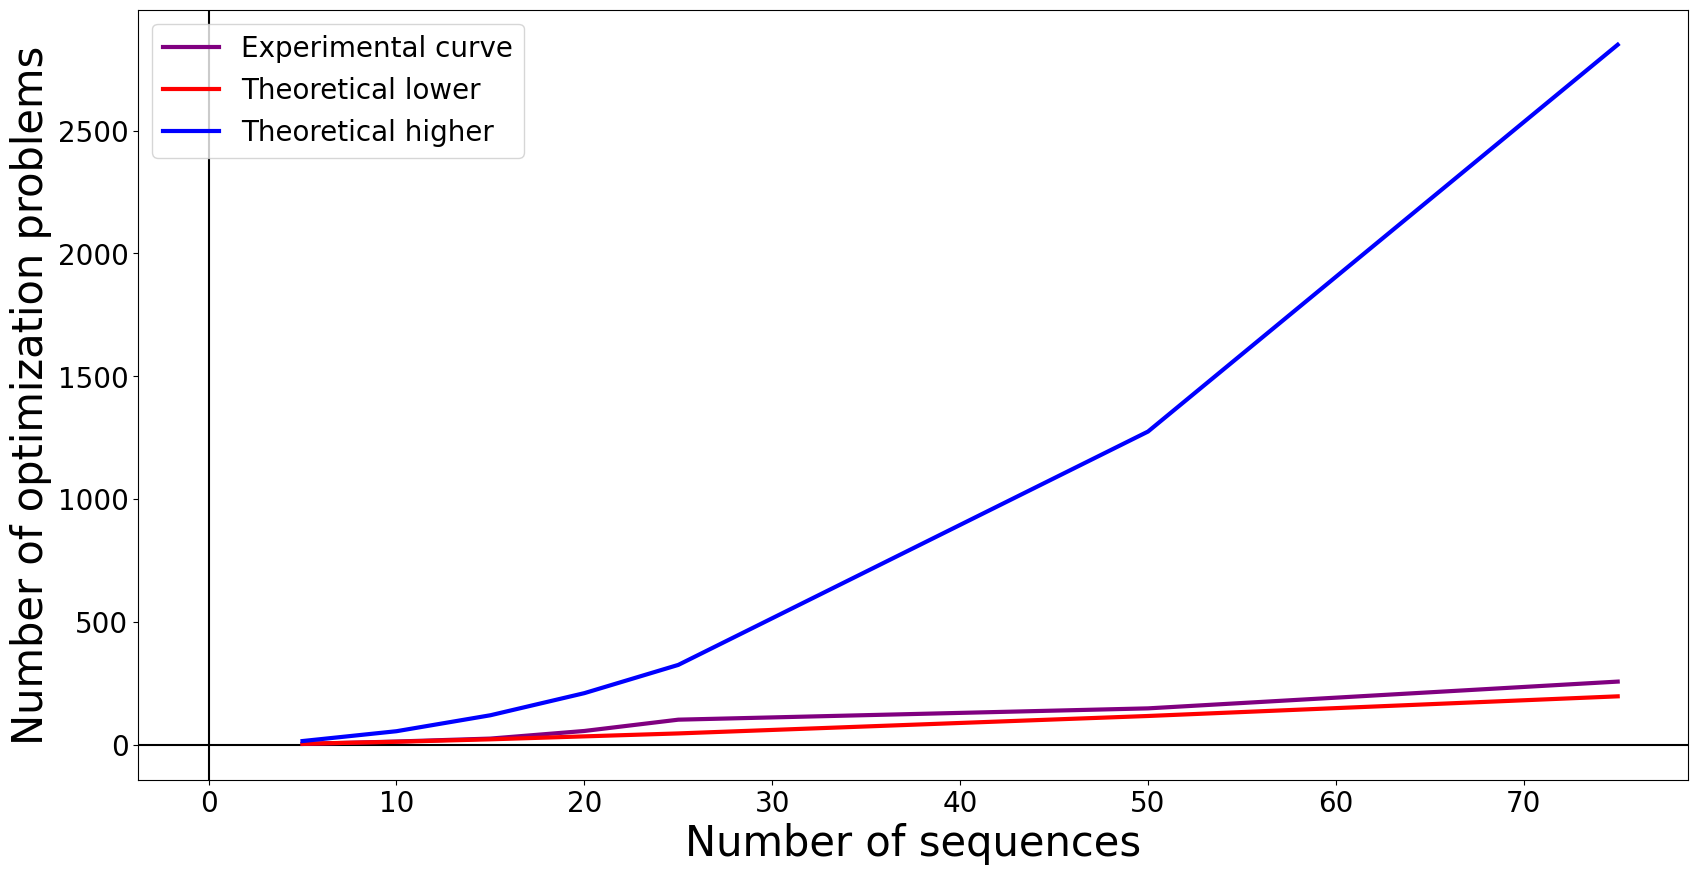

In [47]:
def max_iter(x):
    iter = x*(x+1)/2
    return iter

def min_iter(x):
    iter = np.ceil((x/2)*np.log2(x/2))
    return iter

x = np.arange(3,250)
y1 = max_iter(x)
y2 = min_iter(x)

x = [5,10,15,20,25,50,75]
y = [3,13,25,56,102,148,257]

y_low = min_iter(np.array(x))
y_high = max_iter(np.array(x))
fig, ax = plt.subplots(figsize=(20,10))
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.plot(x, y,color='purple',label='Experimental curve',linewidth=3)
plt.plot(x,y_low,color='red',label='Theoretical lower',linewidth=3)
plt.plot(x,y_high,color='blue',label='Theoretical higher',linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of sequences',fontsize=30)
plt.ylabel('Number of optimization problems',fontsize=30)
plt.legend(fontsize=20,loc='upper left')
plt.show()

---

# Max Cut

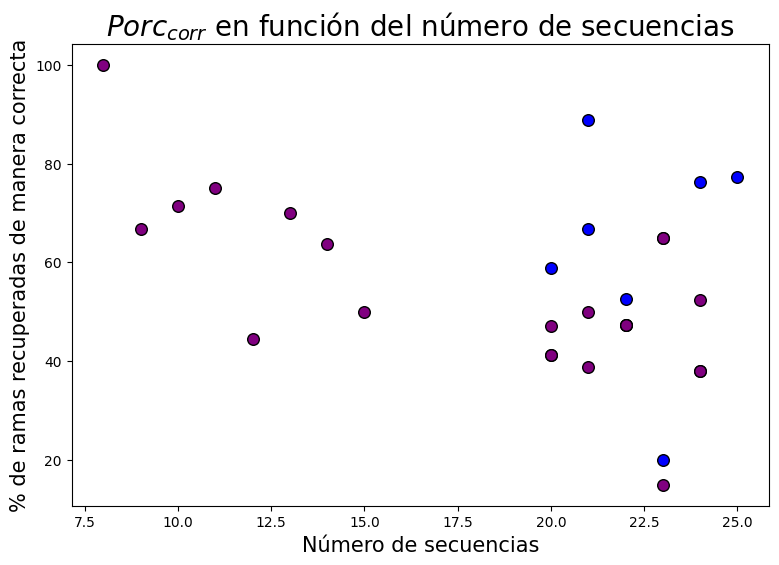

In [48]:
max_cut_df = pd.read_csv('metrics/RF-distance_bf_maxcut.csv')


# Plot the data
plt.subplots(figsize=(9, 6))
plt.scatter(rf_bf['size'], rf_bf['RF'], edgecolor='k', color='blue', s=70)
plt.scatter(max_cut_df['size'], max_cut_df['RF'], edgecolor='k', color='purple', s=70)
# plt.plot(grouped_df['size'], grouped_df['Media RF'], color='red', lw=2)
plt.xlabel('Número de secuencias',fontdict={'fontsize': 15})
plt.ylabel('% de ramas recuperadas de manera correcta',fontdict={'fontsize': 15})
plt.title('$Porc_{corr}$ en función del número de secuencias', fontsize=20)
plt.show()

### Branch length study

We will try to see if the mean branch length matters for QA.


In [49]:
branch_size = pd.read_csv('metrics/branch_length.csv')
branch_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TREE_ID             33 non-null     int64  
 1   NUM_TAXA            33 non-null     int64  
 2   BRANCH_LENGTH_MEAN  33 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 924.0 bytes


In [50]:
df2 = rf.rename(columns={'id': 'TREE_ID'})
df2['TREE_ID'] = df2['TREE_ID'].astype(int)

merged_df = pd.merge(branch_size, df2, on='TREE_ID', how='inner')

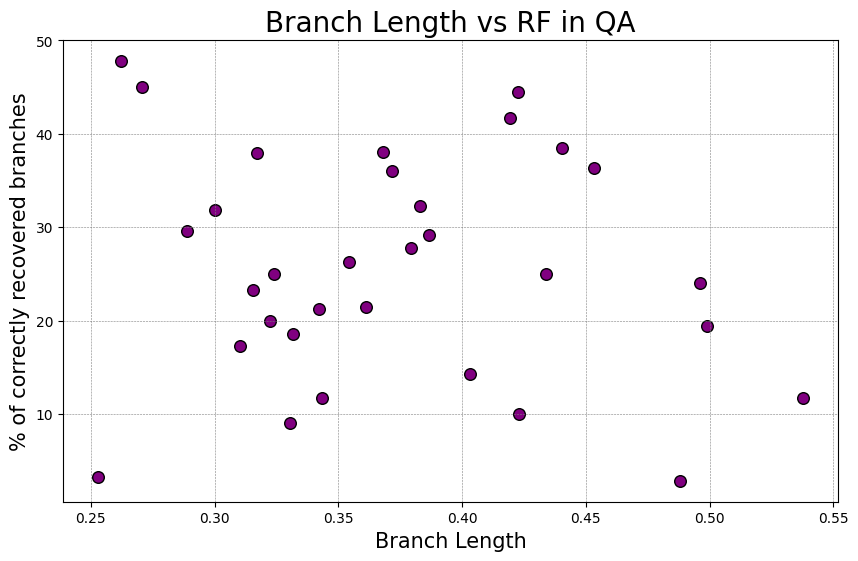

In [51]:
# Plot the branch lengths against RF
plt.subplots(figsize=(10, 6))
plt.scatter(merged_df['BRANCH_LENGTH_MEAN'], merged_df['RF'], edgecolor='k', color='purple', s=70)
plt.xlabel('Branch Length', fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches', fontdict={'fontsize': 15})
plt.title('Branch Length vs RF in QA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

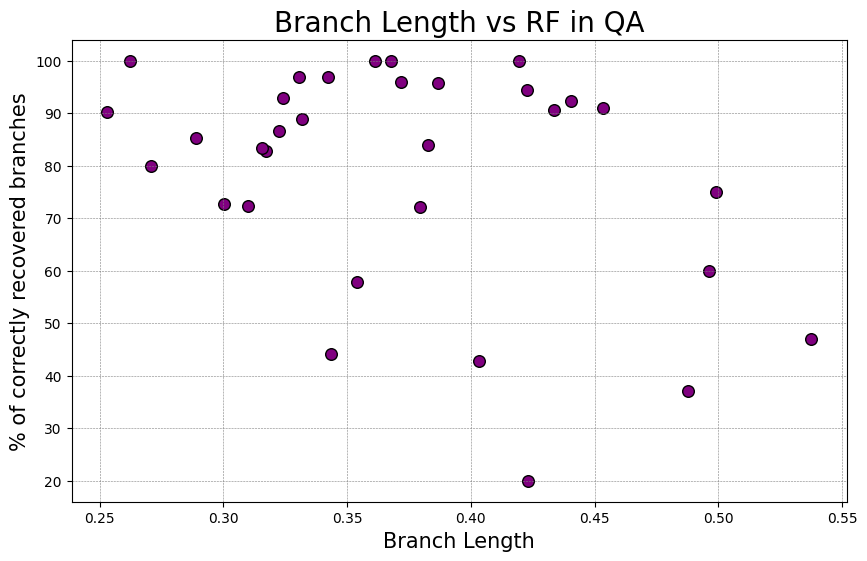

In [52]:
df3 = rf_nf.rename(columns={'id': 'TREE_ID'})
df3['TREE_ID'] = df3['TREE_ID'].astype(int)

merged_df2 = pd.merge(branch_size, df3, on='TREE_ID', how='inner')

# Plot the branch lengths against RF
plt.subplots(figsize=(10, 6))
plt.scatter(merged_df2['BRANCH_LENGTH_MEAN'], merged_df2['RF'], edgecolor='k', color='purple', s=70)
plt.xlabel('Branch Length', fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches', fontdict={'fontsize': 15})
plt.title('Branch Length vs RF in QA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

In [53]:
# sort the merged DataFrame by 'branch_length_mean' in descending order
merged_df = merged_df.sort_values(by='BRANCH_LENGTH_MEAN', ascending=False)
merged_df2 = merged_df2.sort_values(by='BRANCH_LENGTH_MEAN', ascending=False)

Comparison

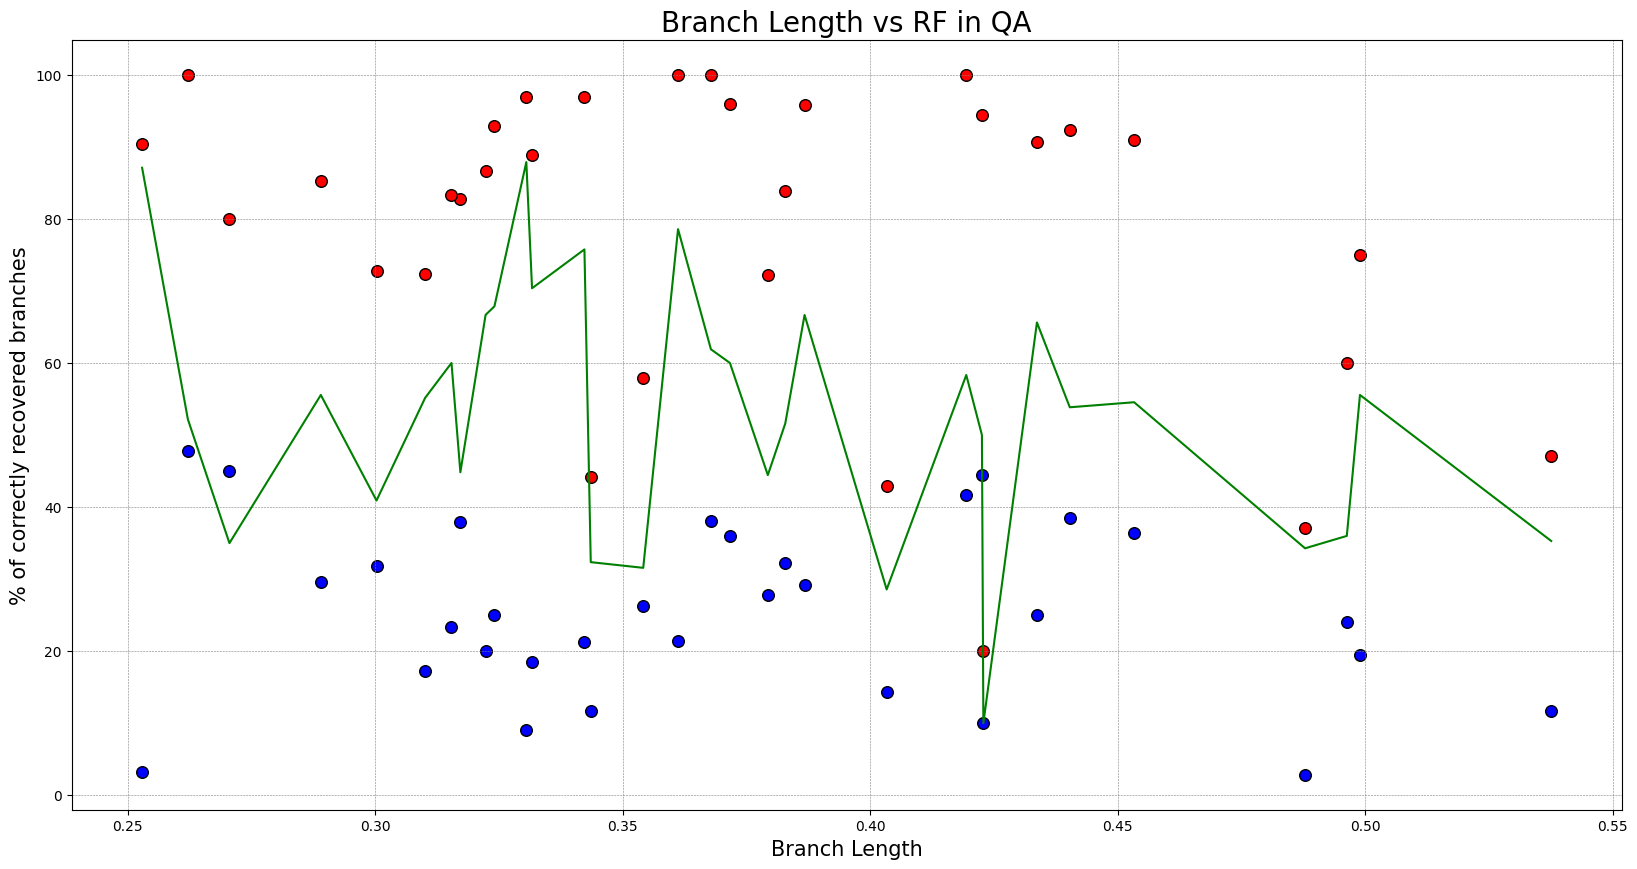

In [54]:
plt.subplots(figsize=(20, 10))
plt.scatter(merged_df2['BRANCH_LENGTH_MEAN'], merged_df2['RF'], edgecolor='k', color='red', s=70)
plt.scatter(merged_df['BRANCH_LENGTH_MEAN'], merged_df['RF'], edgecolor='k', color='blue', s=70)
plt.plot(merged_df['BRANCH_LENGTH_MEAN'], np.abs(merged_df2['RF'] - merged_df['RF']), color='green')
plt.xlabel('Branch Length', fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches', fontdict={'fontsize': 15})
plt.title('Branch Length vs RF in QA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

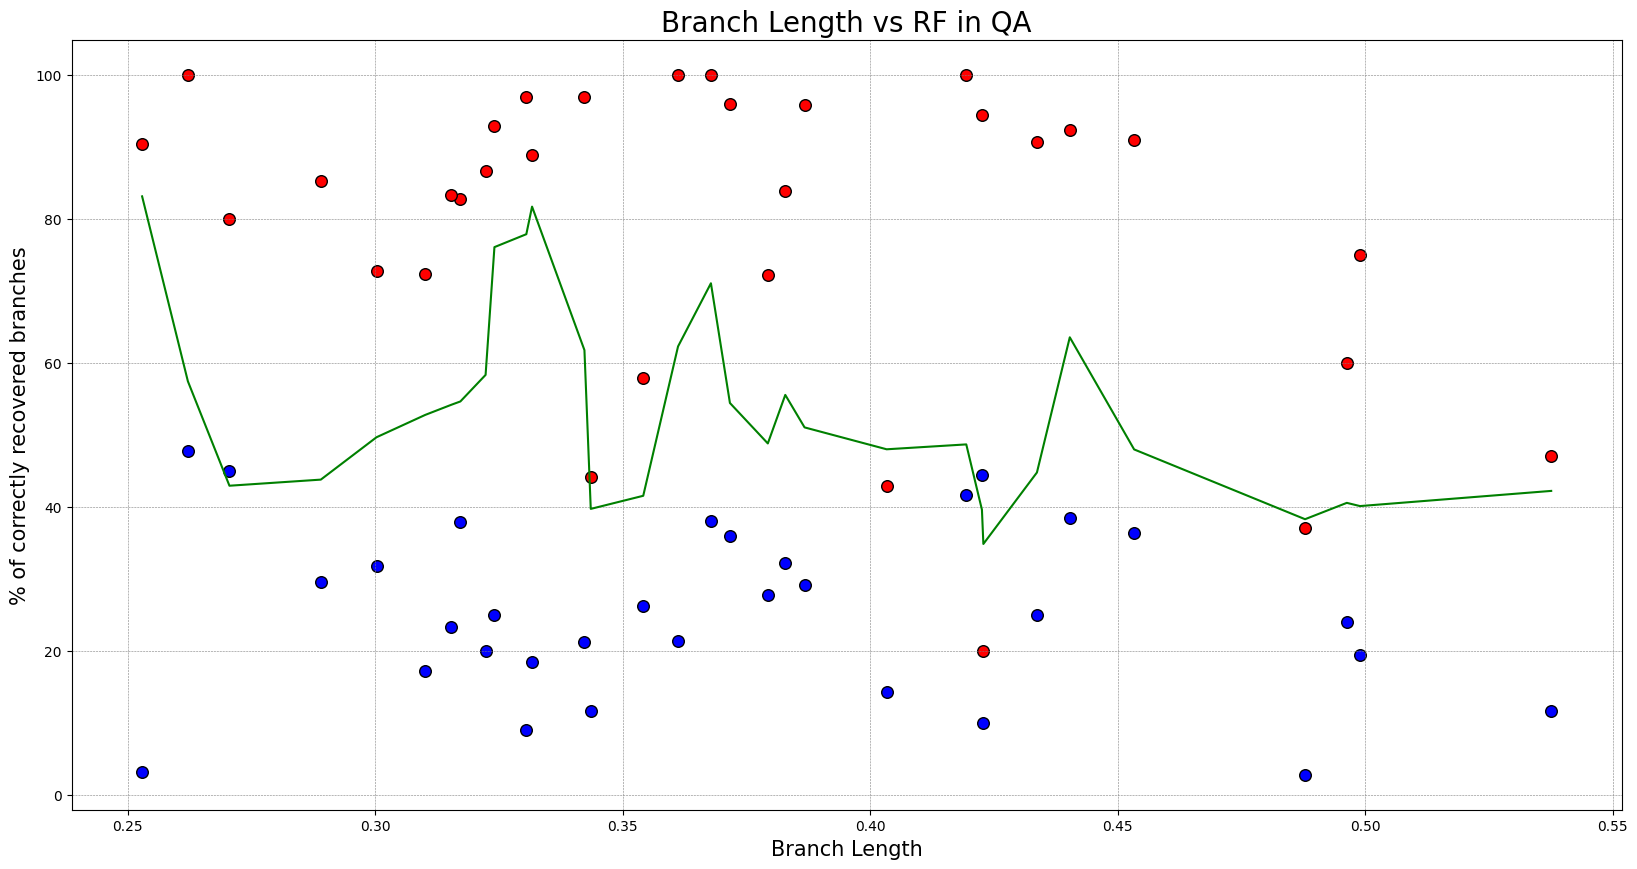

In [55]:
from scipy.signal import savgol_filter

def smooth_savgol(series, window_length=5, polyorder=2):
    return savgol_filter(series, window_length=window_length, polyorder=polyorder)

rf_diff = np.abs(merged_df2['RF'] - merged_df['RF'])

# Step 2: Smooth the difference (using Savitzky–Golay filter)
# window_length must be odd and <= len(rf_diff)
smoothed_rf = savgol_filter(rf_diff, window_length=5, polyorder=2)

plt.subplots(figsize=(20, 10))
plt.scatter(merged_df2['BRANCH_LENGTH_MEAN'], merged_df2['RF'], edgecolor='k', color='red', s=70)
plt.scatter(merged_df['BRANCH_LENGTH_MEAN'], merged_df['RF'], edgecolor='k', color='blue', s=70)
plt.plot(merged_df['BRANCH_LENGTH_MEAN'], smoothed_rf, color='green')
plt.xlabel('Branch Length', fontdict={'fontsize': 15})
plt.ylabel('% of correctly recovered branches', fontdict={'fontsize': 15})
plt.title('Branch Length vs RF in QA', fontsize=20)
plt.grid(color='gray', linestyle='--', linewidth=0.4)
plt.show()

### Relative distance

In [56]:
bf = np.array(rf_bf['RF'])
qisk = np.array(filtered_qiskit['RF'])
qa = np.array(filtered_rf['RF'])

relative_dist_qa = np.abs(qa - bf) / bf*100
relative_dist_qisk = np.abs(qisk - bf) / bf*100

print(relative_dist_qa.mean())
print(relative_dist_qisk.mean())

ValueError: operands could not be broadcast together with shapes (19,) (11,) 

# Advantage 2

We can see that the Advantage 2 QPU obtains the solution in more time

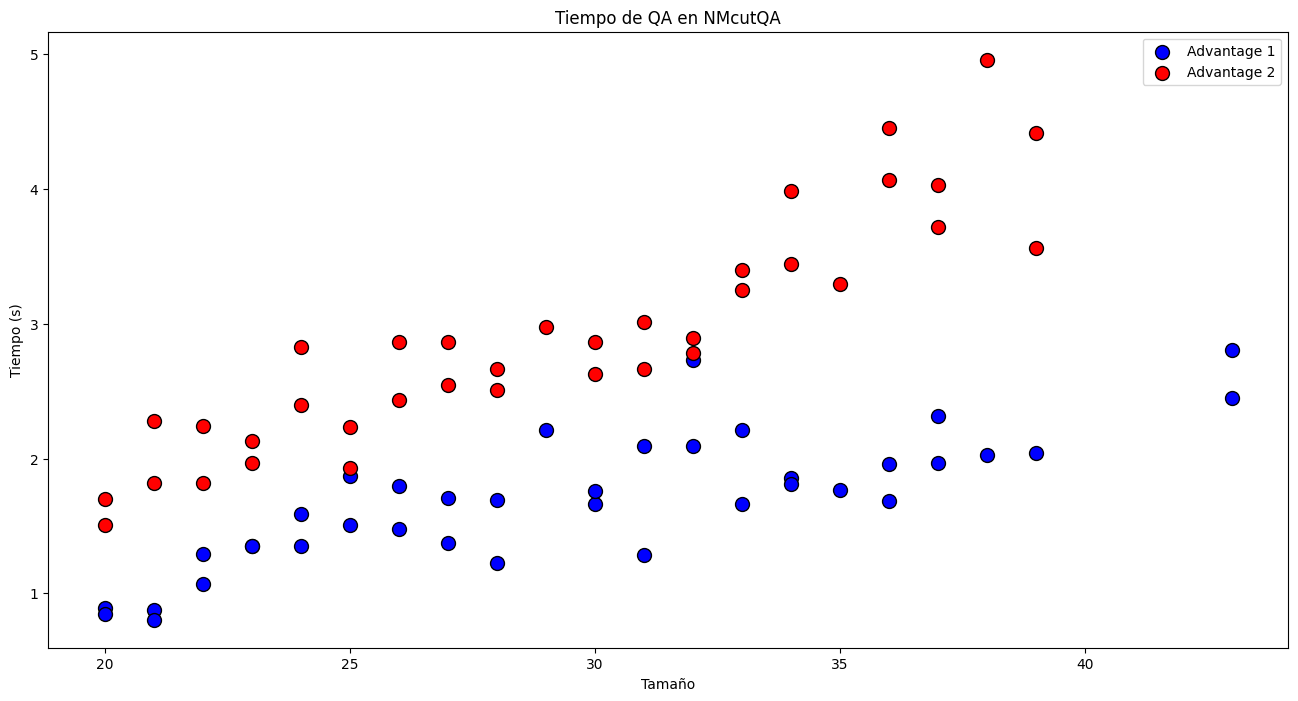

In [ ]:
time_a1 = pd.read_csv('metrics/timer.csv')
time_a1 = time_a1[time_a1['size']<50]

time_a2 = pd.read_csv('metrics/timer_advantage2.csv')

plt.figure(figsize=(16, 8))
plt.scatter(time_a1['size'], time_a1['time']/1000, color='blue', edgecolor='k',s=100,label="Advantage 1")
plt.scatter(time_a2['size'], time_a2['time']/1000, color='red', edgecolor='k',s=100,label="Advantage 2")
plt.xlabel('Tamaño')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo de QA en NMcutQA')
plt.legend()
plt.show()

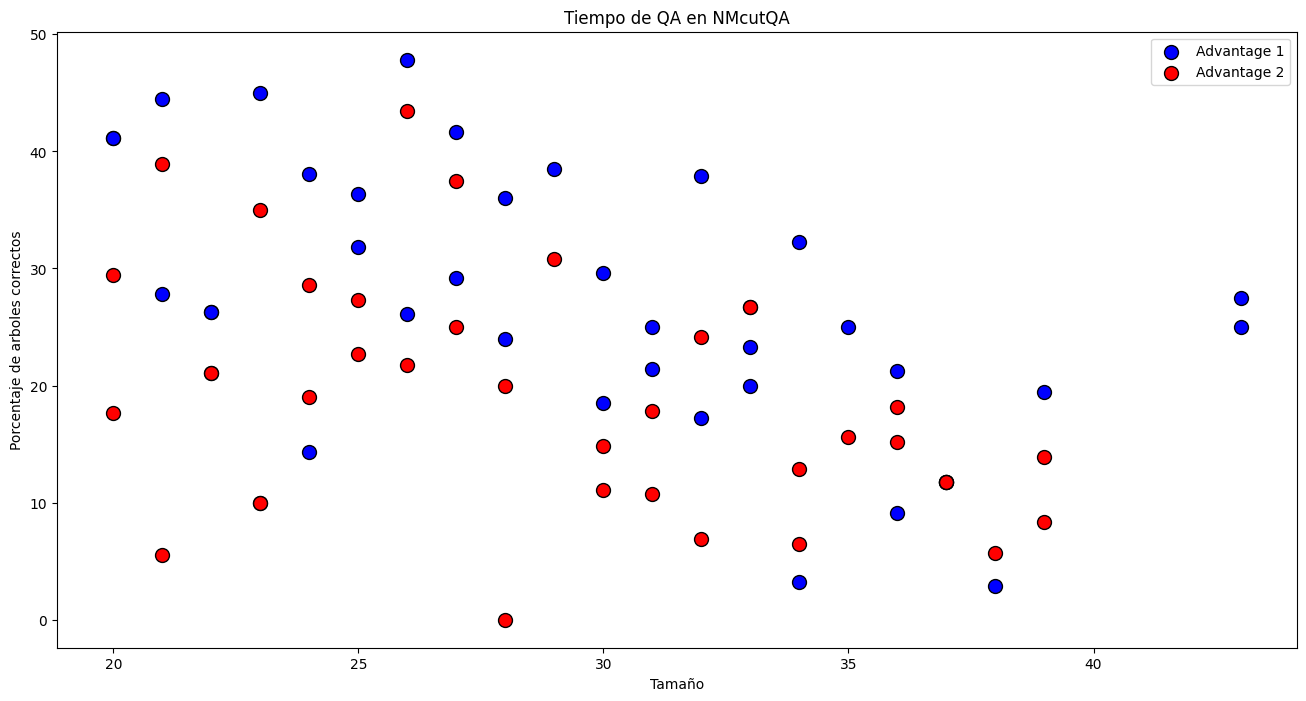

In [ ]:
rf_adv1 = pd.read_csv('metrics/RF-distance.csv')
rf_adv2 = pd.read_csv('metrics/RF-distance-adv2.csv')

plt.figure(figsize=(16, 8))
plt.scatter(rf_adv1['size'], rf_adv1['RF'], color='blue', edgecolor='k',s=100,label="Advantage 1")
plt.scatter(rf_adv2['size'], rf_adv2['RF'], color='red', edgecolor='k',s=100,label="Advantage 2")
plt.xlabel('Tamaño')
plt.ylabel('Porcentaje de arboles correctos')
plt.title('Tiempo de QA en NMcutQA')
plt.legend()
plt.show()